In [ ]:
"""
This is the code for PRESTO: Privacy Recommendation and Security Optimization tool.

Bayesian optimization is used to automatically select the best privacy mechanism and its optimal epsilon.
Top-3 Recommendations, Confidence Analysis, Performance Explanation, GPU Support, and Visualization.

Metrics Explanations:
- KS Statistic: measures the maximum difference between two cumulative distribution functions; desired value near 0.
- Jensen–Shannon Divergence (JSD): quantifies how two distributions diverge in bits; desired value near 0 bits.
- Pearson Correlation: indicates linear alignment between original and private data; desired value close to +1.
- Mean Utility-Privacy Score: negative root mean square error of privatization; desired to be as high as possible (closer to 0).
- Confidence Interval (CI) Width: range of the 95% confidence interval for the utility score; desired width to be small (e.g., <0.05).
- Reliability: ratio of mean utility score to CI width, reflecting consistency; desired to be high (e.g., >10).

Desired Metrics:
- Similarity Metrics:
    KS ≈ 0 (identical distributions)
    JSD ≈ 0 bits (minimal divergence)
    Pearson ≈ +1 (strong linear fidelity)
- Confidence Metrics:
    mean as high as possible (closer to 0, since we use negative RMSE)
    CI width small (e.g., <0.05 for stable performance)
- Performance Explanation:
    A small confidence interval (CI) width indicates consistent performance across evaluations.
    Reliability is computed as 1 / (RMSE × CI width); higher values (e.g., >10) suggest a reliable and stable privacy-utility trade-off.
"""

'\nThis is the code for PRESTO: Privacy Recommendation and Security Optimization tool.\n\nBayesian optimization is used to automatically select the best privacy mechanism and its optimal epsilon.\nTop-3 Recommendations, Confidence Analysis, Performance Explanation, GPU Support, and Visualization.\n\nMetrics Explanations:\n- KS Statistic: measures the maximum difference between two cumulative distribution functions; desired value near 0.\n- Jensen–Shannon Divergence (JSD): quantifies how two distributions diverge in bits; desired value near 0 bits.\n- Pearson Correlation: indicates linear alignment between original and private data; desired value close to +1.\n- Mean Utility-Privacy Score: negative root mean square error of privatization; desired to be as high as possible (closer to 0).\n- Confidence Interval (CI) Width: range of the 95% confidence interval for the utility score; desired width to be small (e.g., <0.05).\n- Reliability: ratio of mean utility score to CI width, reflecting

In [ ]:
# Install the required library.
!pip install ornl_presto

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.4/254.4 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Import the required libraries.
import ornl_presto

import torch
import random
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from scipy.stats import pearsonr
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

Using device: cpu


In [ ]:
SEED = 42 # Fixed seed for reproducibility; 42 is a popular choice (reference to *The Hitchhiker's Guide to the Galaxy*)
random.seed(SEED) # Set the random seed for Python's built-in random module
np.random.seed(SEED) # Set the seed for NumPy's random number generator
torch.manual_seed(SEED) # Set the seed for PyTorch's random number generator (for CPU)

In [ ]:
# Global device definition for GPU support.
# Selects GPU ('cuda') if available; otherwise falls back to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# If running on a GPU, set the seed for all CUDA devices to ensure reproducibility
if device.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)

# Print the device being used (helpful for debugging and verification)
print(f"Using device: {device}")

Using device: cpu


In [ ]:
## Usecases:

In [ ]:
# Generate synthetic data for testing.

def generate_dataset() -> dict:
    """
    Generates a dictionary of more realistic datasets with varying properties and sizes.
    """
    datasets = {}
    # 1) Energy: base consumption: sinusoidal daily pattern + trend + noise
    hours = np.arange(0, 168)
    daily_pattern = 2.0 * np.sin(2 * np.pi * hours / 24)
    trend = 0.01 * hours
    noise = np.random.normal(0, 0.3, size=hours.shape)
    consumption = 5.0 + daily_pattern + trend + noise
    datasets["Energy (Hourly)"] = torch.tensor(consumption, dtype=torch.float32) # Convert to PyTorch tensor

    # 2) Finance: heavy-tailed log-normal (10k points)
    datasets["Finance (Log-Normal)"] = torch.exp(
        torch.normal(mean=3.5, std=1.2, size=(10000,), device=device)
    )
    # 3) IoT Sensor: temperature readings with daily cycle + noise (7d × 24h = 168)
    hours = torch.arange(0, 168, device=device)
    daily = 10 * torch.sin(2 * np.pi * hours / 24)
    trend = 0.01 * hours
    noise = torch.randn(168, device=device) * 0.5
    datasets["Sensor Temp (Hourly)"] = 20.0 + daily + trend + noise

    # 4) Medical: heart rate minute-resolution (24h = 1440 points)
    minutes = torch.arange(0, 1440, device=device)
    circadian = 15 * torch.sin(2 * np.pi * minutes / 1440)
    hr_noise = torch.randn(1440, device=device) * 2
    datasets["Heart Rate (Min)"] = 70.0 + circadian + hr_noise

    # 5) Web Traffic: Poisson-like bursty arrivals (5k points)
    lam = torch.linspace(5, 20, steps=5000, device=device)
    datasets["Web Hits (5k)"] = torch.poisson(lam)

    # 6) Mixed categorical/numerical: small domain + noise (2k points)
    cat = torch.randint(0, 5, (2000,), device=device)
    num = torch.randn(2000, device=device) * 3 + 10
    # interleave so that code paths for categorical get exercised
    datasets["Cat+Num"] = torch.stack([cat.float(), num], dim=1).view(-1)

    return datasets

In [ ]:
# Create a list of privacy algorithms.
NOISE_GENERATORS = ornl_presto.get_noise_generators()

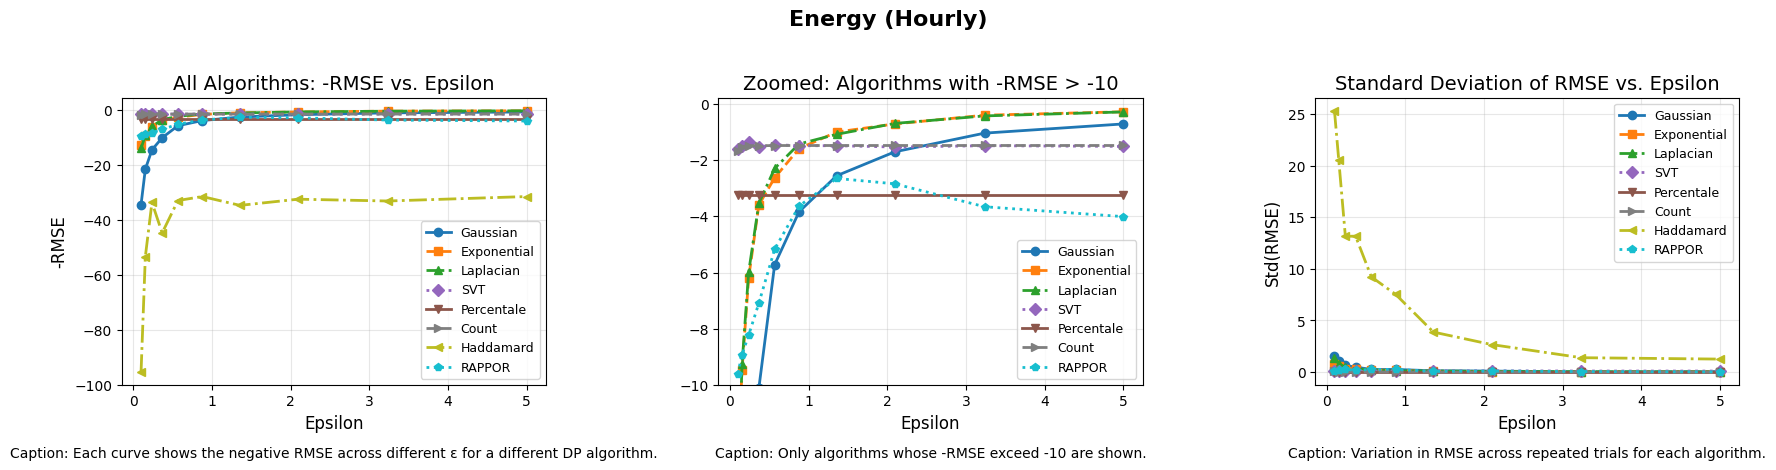

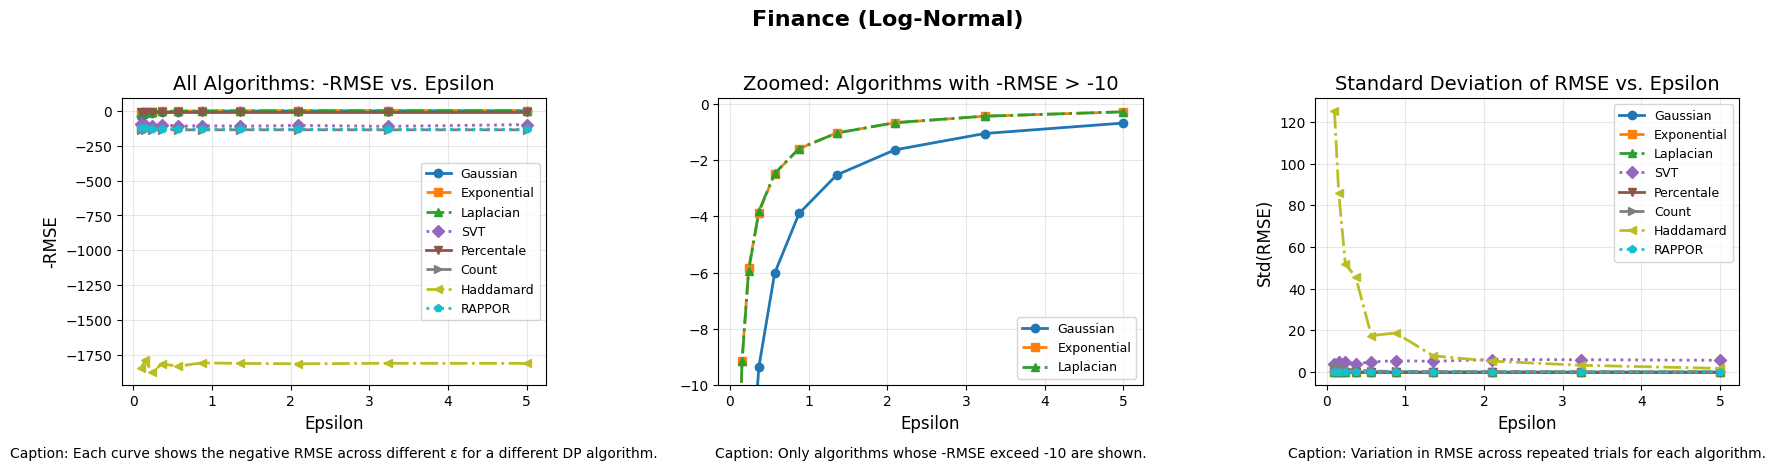

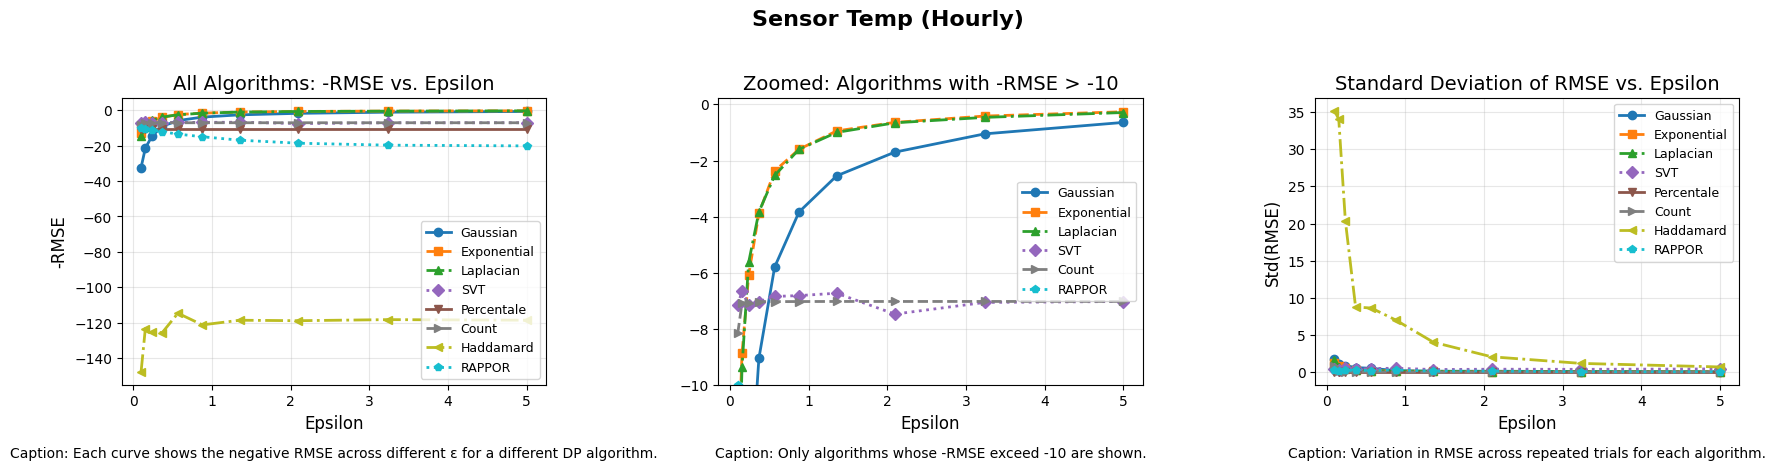

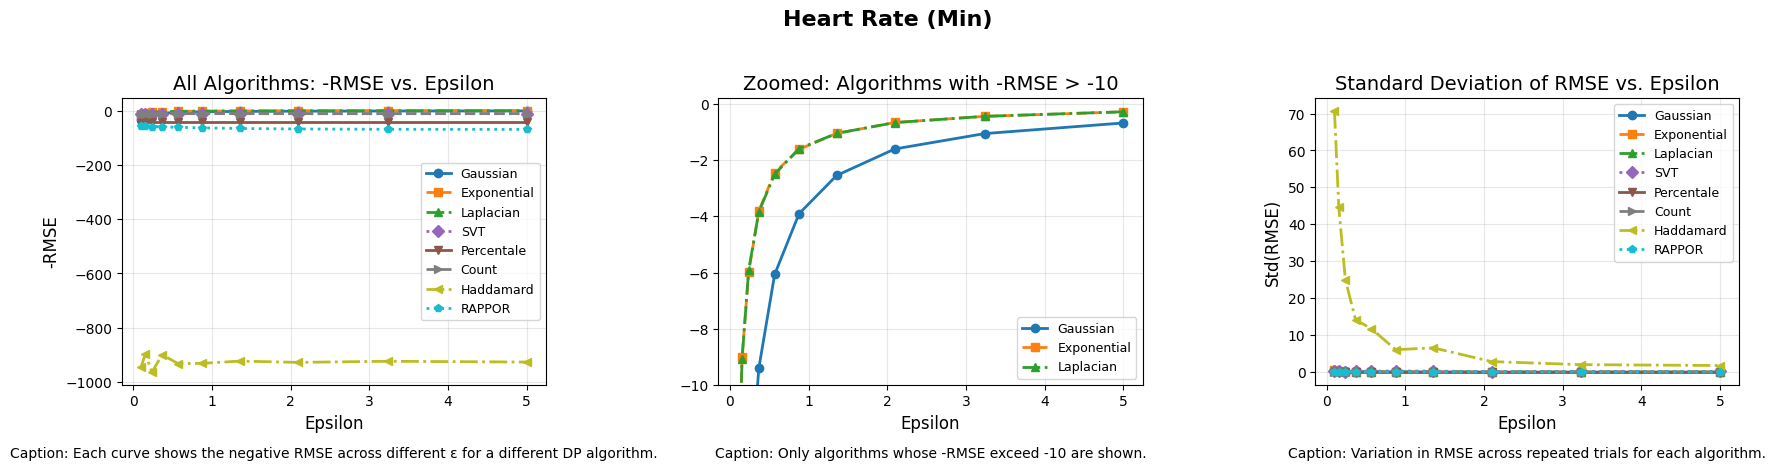

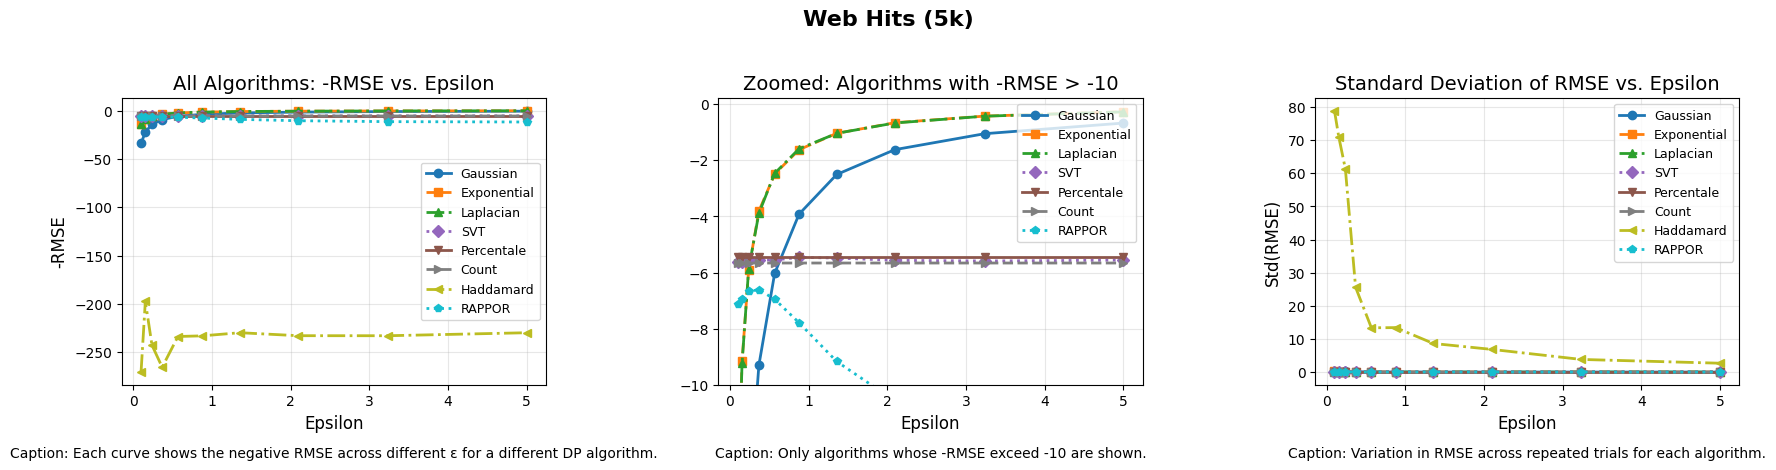

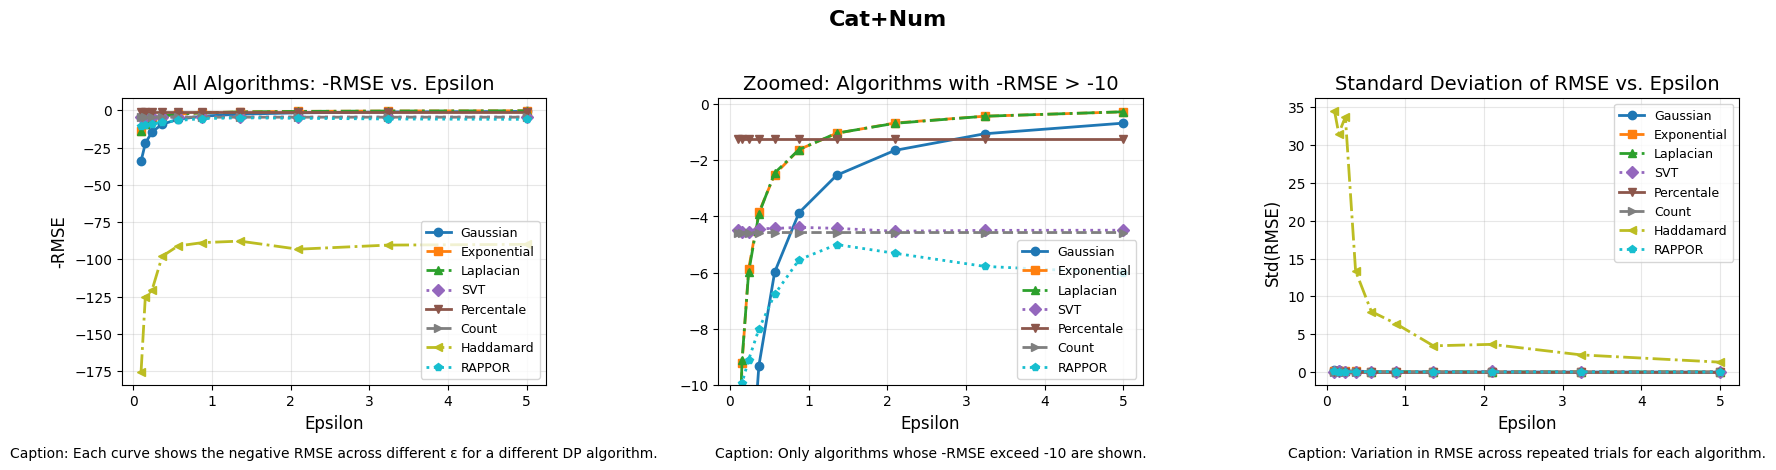

In [ ]:
# Calculate how each privacy algorithm performs under different privacy loss (epsilon ε).

colormap = plt.get_cmap('tab10')

num_colors = len(NOISE_GENERATORS)
color_positions = np.linspace(0, 1, num_colors)
colors = colormap(color_positions)

dp_names = ['Gaussian', 'Exponential', 'Laplacian', 'SVT', 'Percentale', 'Count', 'Haddamard', 'RAPPOR']

def ranking_compute(domain, n_evals=3, init_points=2, n_iter=5):
    # this code evaluates estimated RMSE for a given dataset (domain) for varying noise generators and epsilon
    epsilon_ = np.logspace(np.log10(.1),np.log10(5),10)
    mean_neg_rmse = np.zeros((len(NOISE_GENERATORS),epsilon_.shape[0]))
    std_rmse = np.zeros((len(NOISE_GENERATORS),epsilon_.shape[0]))
    mean_rmse = np.zeros((len(NOISE_GENERATORS),epsilon_.shape[0]))
    results = []

    for i,key in enumerate(NOISE_GENERATORS): # vary noise generator
        def target(x_epsilon):
            return float(np.mean([ornl_presto.calculate_utility_privacy_score(domain, key, x_epsilon) for _ in range(n_evals)]))
        for j,epsilon in enumerate(epsilon_): # vary epsilon
            mean_neg_rmse[i,j] = target(epsilon)
            conf = ornl_presto.evaluate_algorithm_confidence(domain, key, epsilon)

            mean_rmse[i,j] = conf['mean']
            std_rmse[i,j] = conf['std']

            perf = ornl_presto.performance_explanation_metrics(conf)
            results.append({
                'algorithm': key,
                'epsilon': epsilon,
                'mean_neg_rmse': mean_neg_rmse[i,j],
                **perf
        })

    return epsilon_, mean_neg_rmse, mean_rmse, std_rmse, results # sorted(results, key=lambda x: (x['mean_rmse'], -x['ci_width']), reverse=True)[:3]

def ranking_plot(x, y, ym, ys, colors, data_name, dp_names):
    """
    Plots three panels side by side with captions:
      1) All algorithms’ -RMSE curves
      2) Zoomed subset: only algorithms where -RMSE > -10
      3) Std(RMSE) curves

    Parameters:
    - x         : 1D array of epsilon values (M,)
    - y         : 2D array of -RMSE (N_algos, M)
    - ym        : unused placeholder (kept for API)
    - ys        : 2D array of std(RMSE) (N_algos, M)
    - colors    : array‐like of shape (N_algos, 3) or list of color specs
    - data_name : figure title
    - dp_names  : list of algorithm names (length N_algos)
    """
    N = y.shape[0]
    linestyles = ['-', '--', '-.', ':'] * ((N // 4) + 1)
    markers    = ['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h', '*'] * ((N // 10) + 1)

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
    fig.suptitle(data_name, fontsize=16, weight='bold')

    # Panel 1: all -RMSE curves
    ax1 = axes[0]
    for i in range(N):
        ax1.plot(
            x, y[i],
            label=dp_names[i],
            color=colors[i],
            linestyle=linestyles[i],
            marker=markers[i],
            linewidth=2,
            markersize=6
        )
    ax1.set_xlabel("Epsilon", fontsize=12)
    ax1.set_ylabel("-RMSE", fontsize=12)
    ax1.grid(alpha=0.3)
    ax1.legend(loc='best', fontsize=9)
    ax1.set_title("All Algorithms: -RMSE vs. Epsilon", fontsize=14)
    ax1.text(
        0.5, -0.25,
        "Caption: Each curve shows the negative RMSE across different ε for a different DP algorithm.",
        transform=ax1.transAxes, ha='center', fontsize=10
    )

    # Identify algorithms where max(-RMSE) > -10
    indices_zoom = [i for i in range(N) if np.max(y[i]) > -10]

    # Panel 2: zoomed subset (-RMSE > -10)
    ax2 = axes[1]
    y_upper = np.max(y) + 0.5
    for i in indices_zoom:
        ax2.plot(
            x, y[i],
            label=dp_names[i],
            color=colors[i],
            linestyle=linestyles[i],
            marker=markers[i],
            linewidth=2,
            markersize=6
        )
    ax2.set_ylim(-10, y_upper)
    ax2.set_xlabel("Epsilon", fontsize=12)
    ax2.grid(alpha=0.3)
    ax2.legend([dp_names[i] for i in indices_zoom], fontsize=9, loc='best')
    ax2.set_title("Zoomed: Algorithms with -RMSE > -10", fontsize=14)
    ax2.text(
        0.5, -0.25,
        "Caption: Only algorithms whose -RMSE exceed -10 are shown.",
        transform=ax2.transAxes, ha='center', fontsize=10
    )

    # Panel 3: Std(RMSE) curves
    ax3 = axes[2]
    for i in range(N):
        ax3.plot(
            x, ys[i],
            label=dp_names[i],
            color=colors[i],
            linestyle=linestyles[i],
            marker=markers[i],
            linewidth=2,
            markersize=6
        )
    ax3.set_xlabel("Epsilon", fontsize=12)
    ax3.set_ylabel("Std(RMSE)", fontsize=12)
    ax3.grid(alpha=0.3)
    ax3.legend(loc='best', fontsize=9)
    ax3.set_title("Standard Deviation of RMSE vs. Epsilon", fontsize=14)
    ax3.text(
        0.5, -0.25,
        "Caption: Variation in RMSE across repeated trials for each algorithm.",
        transform=ax3.transAxes, ha='center', fontsize=10
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

dataset = generate_dataset()
data_iter = iter(dataset.items())

for i in range(len(dataset)):
    name, tensor = next(data_iter)
    domain = tensor.tolist()
    epsilon_, mean_neg_rmse, mean_rmse, std_rmse, results = ranking_compute(domain)
    ranking_plot(epsilon_,mean_neg_rmse, mean_rmse, std_rmse, colors,name, dp_names)


=== Dataset: Energy (Hourly) ===
Top-3 Recommendations:
  DP_Laplace: ε=3.6288, mean_rmse=0.3801, ci_width=0.0351, reliability=74.95
  DP_Exponential: ε=3.6208, mean_rmse=0.4066, ci_width=0.0441, reliability=55.77
  DP_Gaussian: ε=3.6282, mean_rmse=0.9303, ci_width=0.0629, reliability=17.09

Similarity Metrics for Top-3:


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


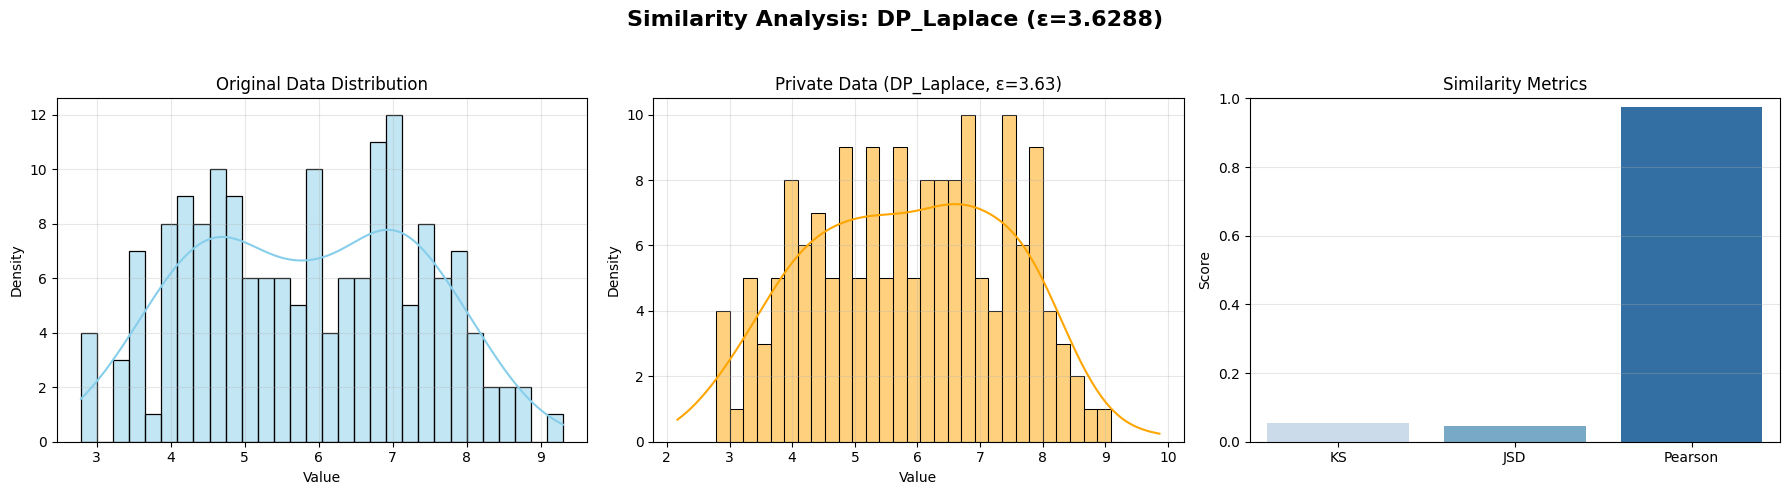

  DP_Laplace: KS=0.0536, JSD=0.0461, Pearson=0.9758


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


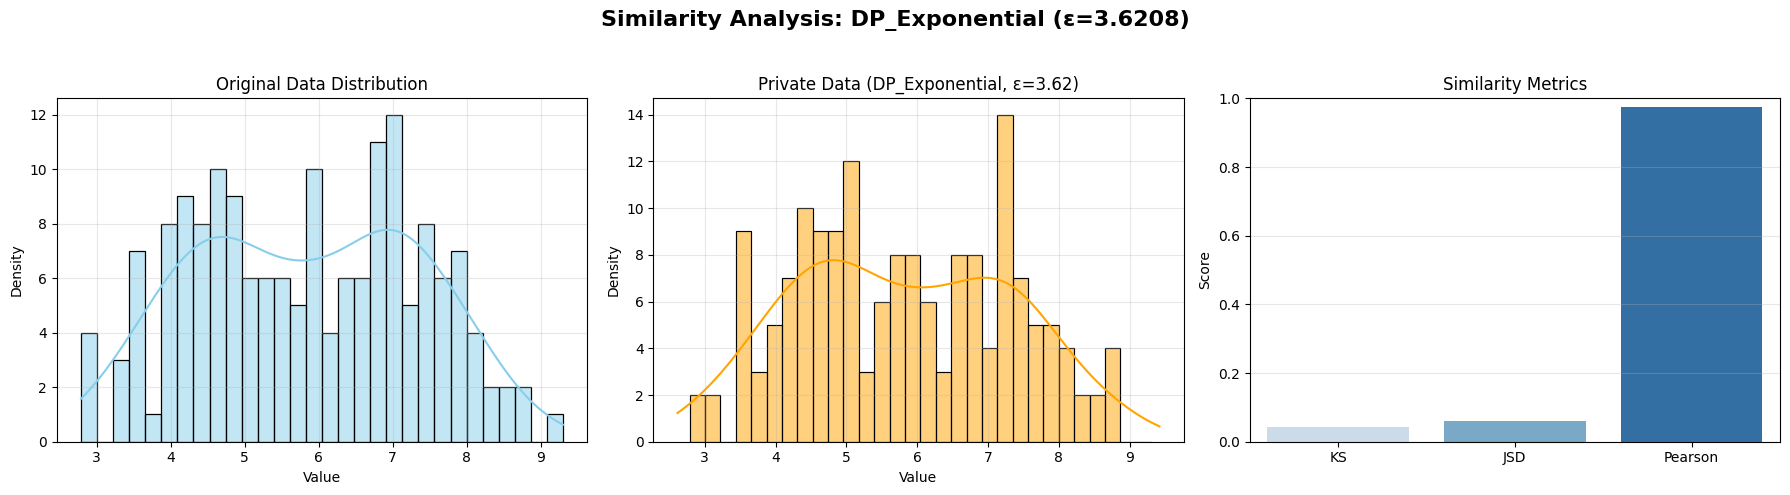

  DP_Exponential: KS=0.0417, JSD=0.0595, Pearson=0.9738


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


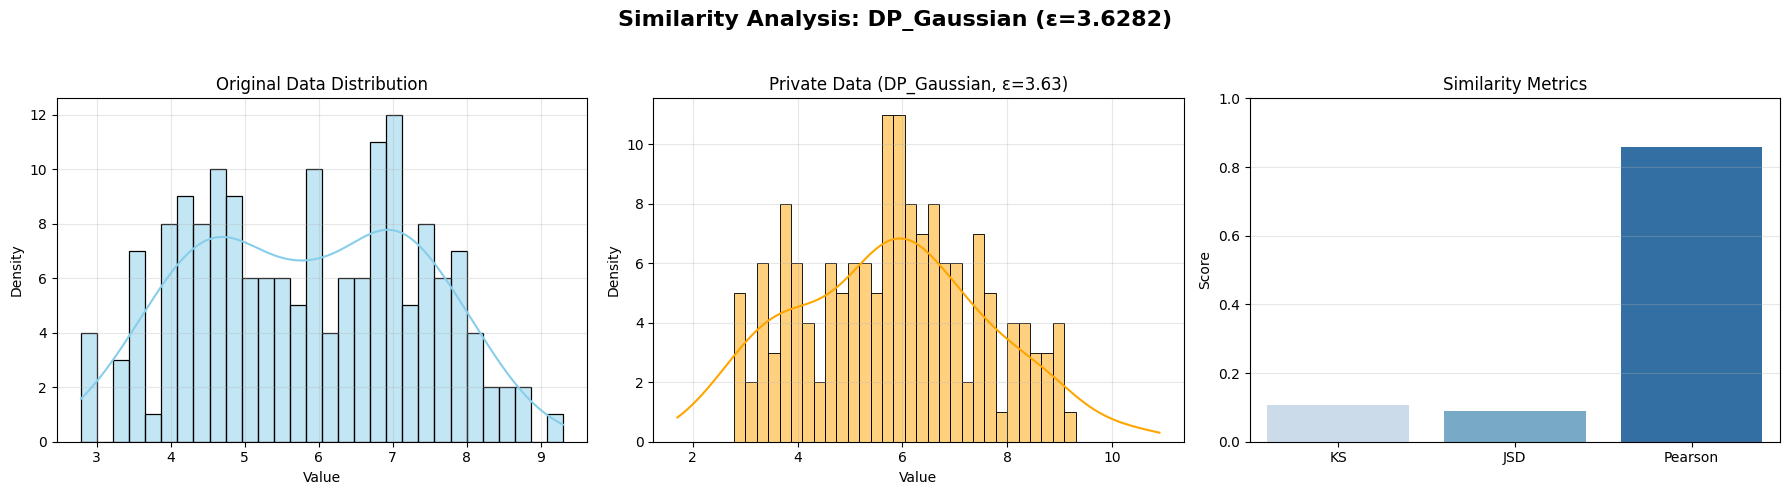

  DP_Gaussian: KS=0.1071, JSD=0.0900, Pearson=0.8592

Confidence Metrics for Top-3:
  DP_Laplace: mean_rmse=0.3932, ci_width=0.0305, reliability=83.38
  DP_Exponential: mean_rmse=0.3825, ci_width=0.0353, reliability=74.27
  DP_Gaussian: mean_rmse=0.9601, ci_width=0.0321, reliability=32.55


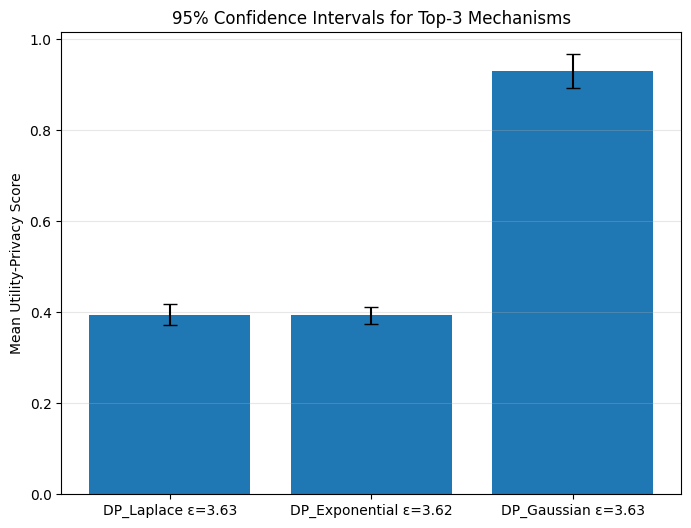

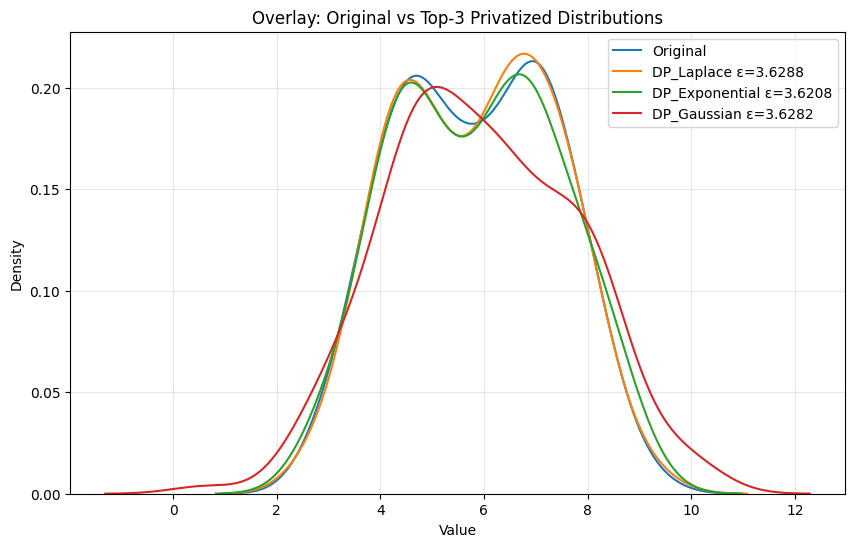


=== Dataset: Finance (Log-Normal) ===
Top-3 Recommendations:
  DP_Laplace: ε=3.6371, mean_rmse=0.3860, ci_width=0.0055, reliability=471.03
  DP_Exponential: ε=3.6254, mean_rmse=0.3878, ci_width=0.0055, reliability=468.85
  DP_Gaussian: ε=3.6241, mean_rmse=0.9447, ci_width=0.0062, reliability=170.73

Similarity Metrics for Top-3:


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


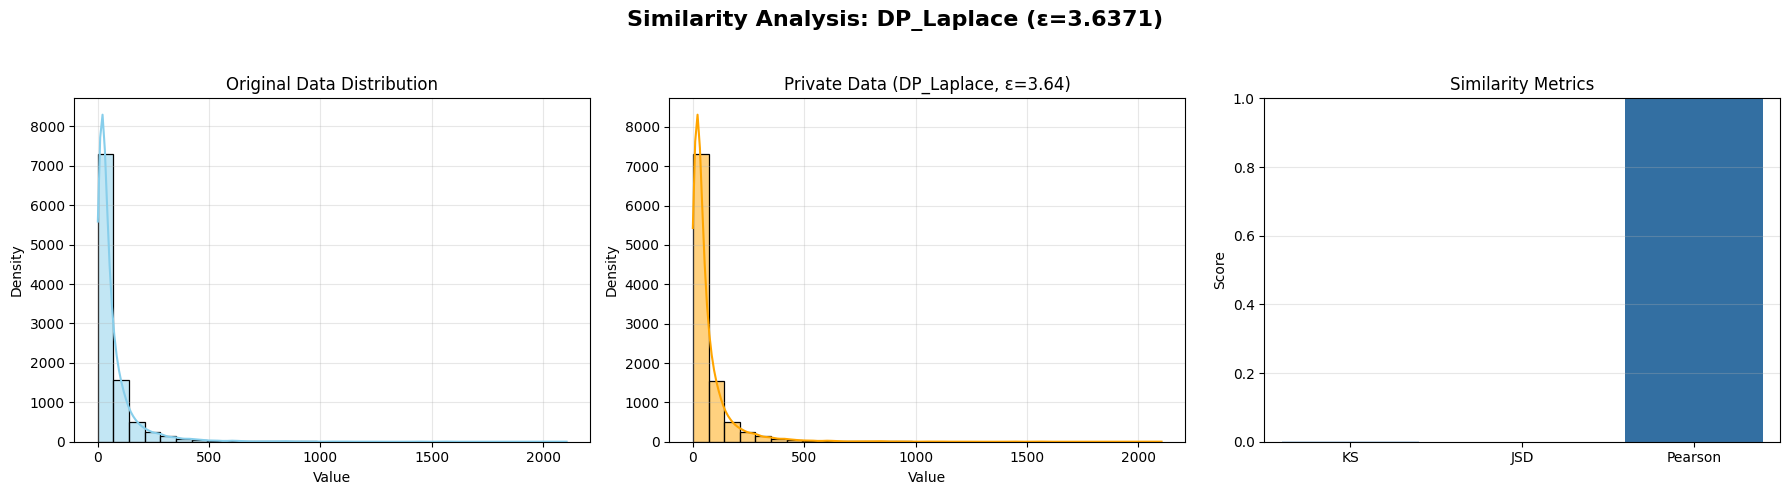

  DP_Laplace: KS=0.0023, JSD=0.0000, Pearson=1.0000


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


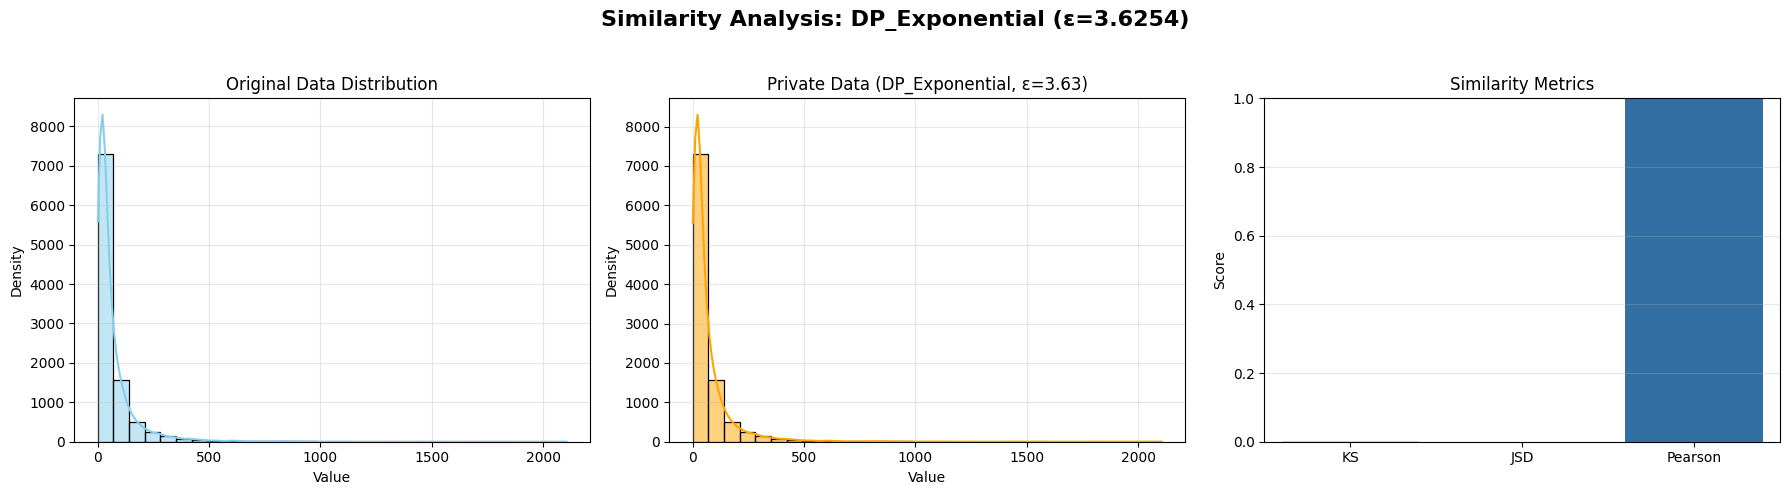

  DP_Exponential: KS=0.0022, JSD=0.0000, Pearson=1.0000


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


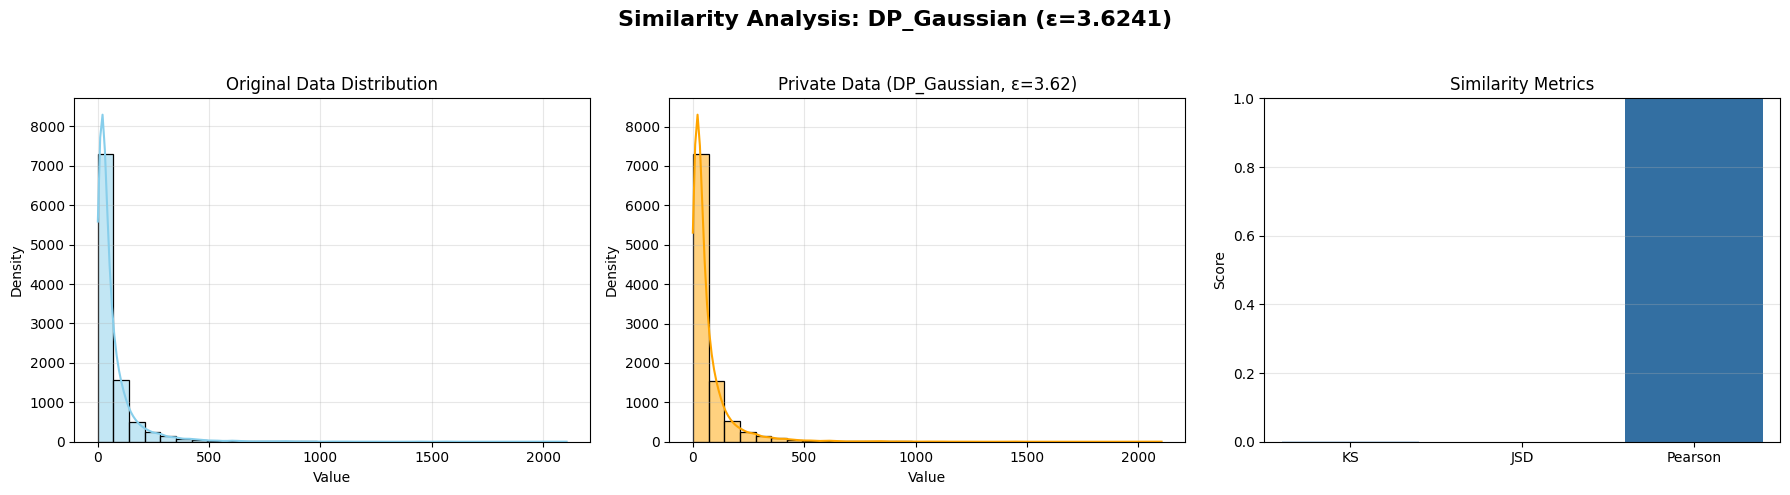

  DP_Gaussian: KS=0.0032, JSD=0.0001, Pearson=1.0000

Confidence Metrics for Top-3:
  DP_Laplace: mean_rmse=0.3896, ci_width=0.0046, reliability=546.11
  DP_Exponential: mean_rmse=0.3905, ci_width=0.0054, reliability=483.17
  DP_Gaussian: mean_rmse=0.9455, ci_width=0.0063, reliability=167.88


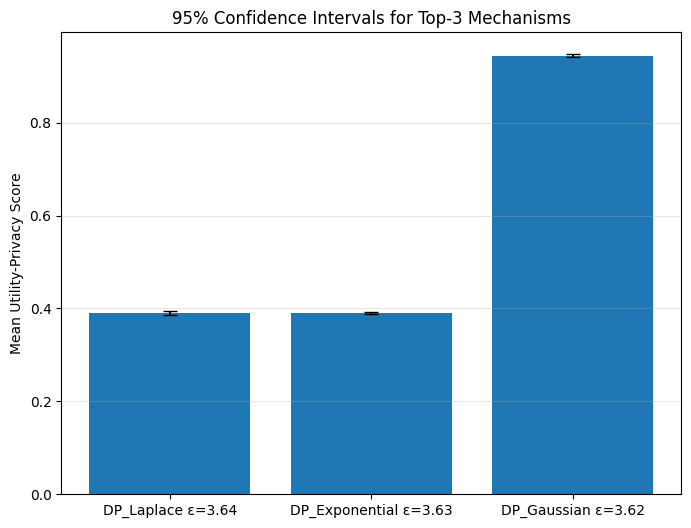

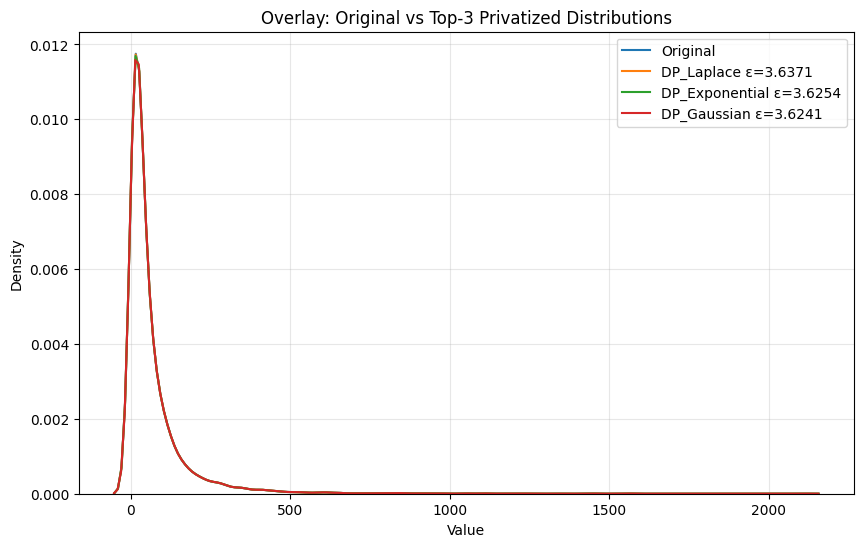


=== Dataset: Sensor Temp (Hourly) ===
Top-3 Recommendations:
  DP_Exponential: ε=3.6296, mean_rmse=0.3858, ci_width=0.0439, reliability=59.04
  DP_Laplace: ε=3.6296, mean_rmse=0.3935, ci_width=0.0481, reliability=52.83
  DP_Gaussian: ε=3.6300, mean_rmse=0.9038, ci_width=0.0647, reliability=17.10

Similarity Metrics for Top-3:


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


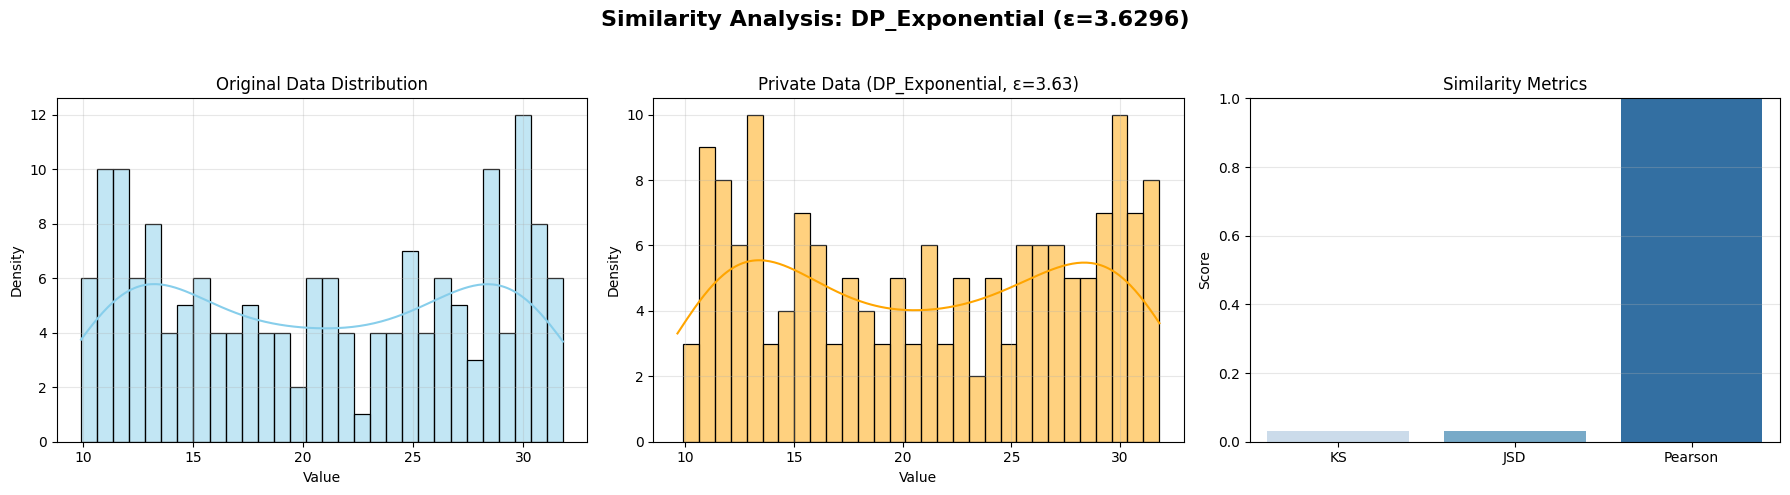

  DP_Exponential: KS=0.0298, JSD=0.0313, Pearson=0.9979


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


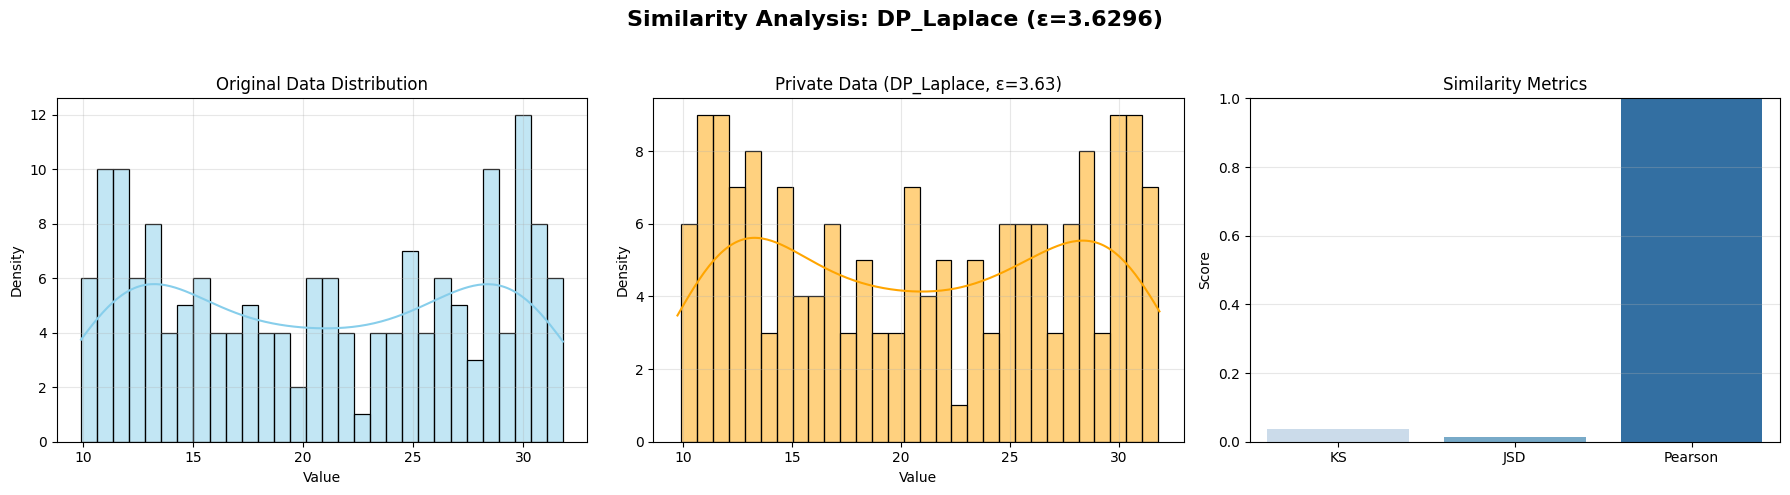

  DP_Laplace: KS=0.0357, JSD=0.0134, Pearson=0.9990


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


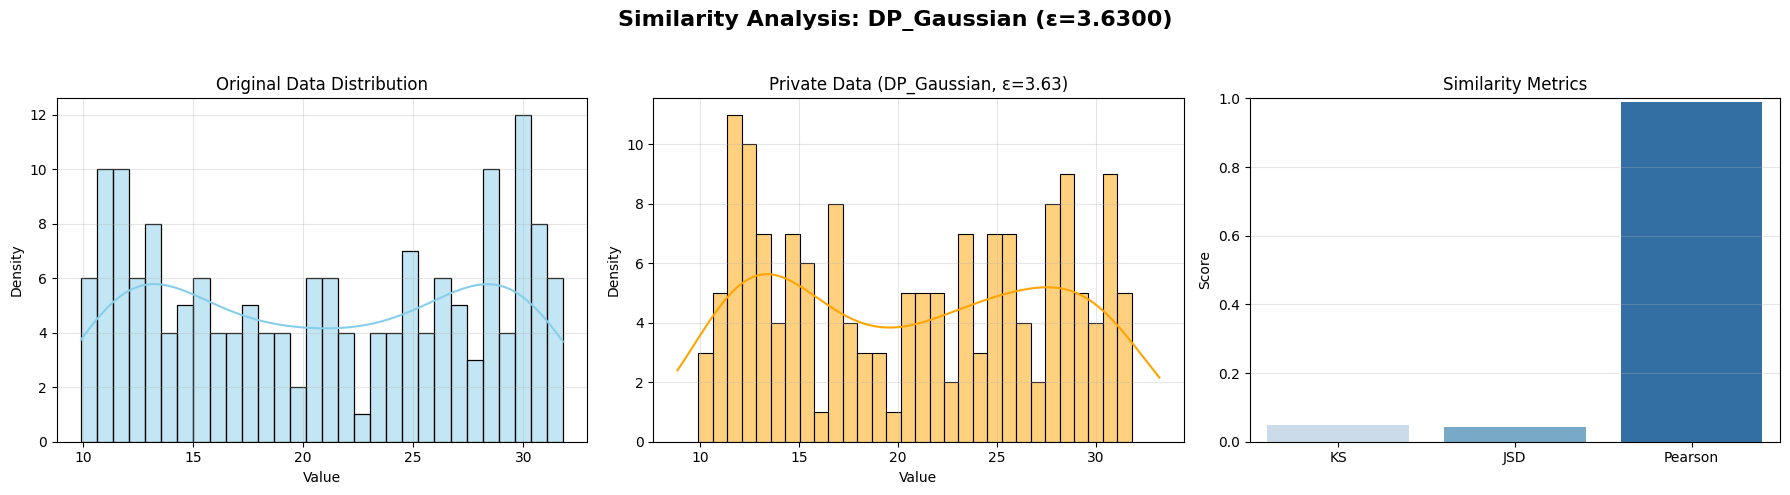

  DP_Gaussian: KS=0.0476, JSD=0.0419, Pearson=0.9905

Confidence Metrics for Top-3:
  DP_Exponential: mean_rmse=0.3823, ci_width=0.0323, reliability=80.98
  DP_Laplace: mean_rmse=0.3909, ci_width=0.0320, reliability=79.94
  DP_Gaussian: mean_rmse=0.9431, ci_width=0.0620, reliability=17.10


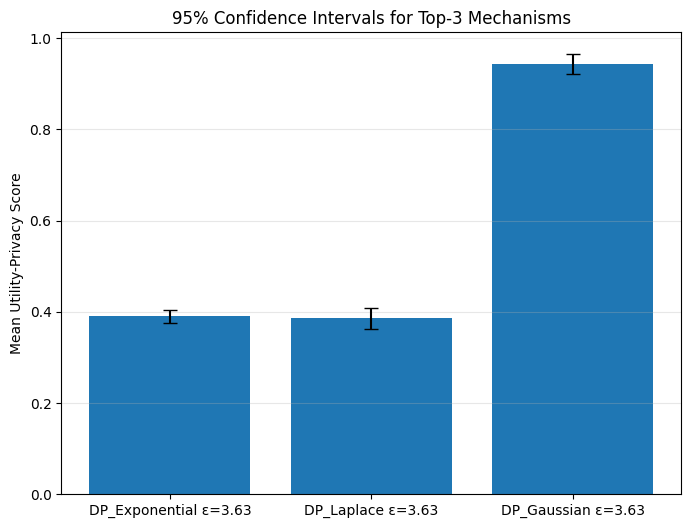

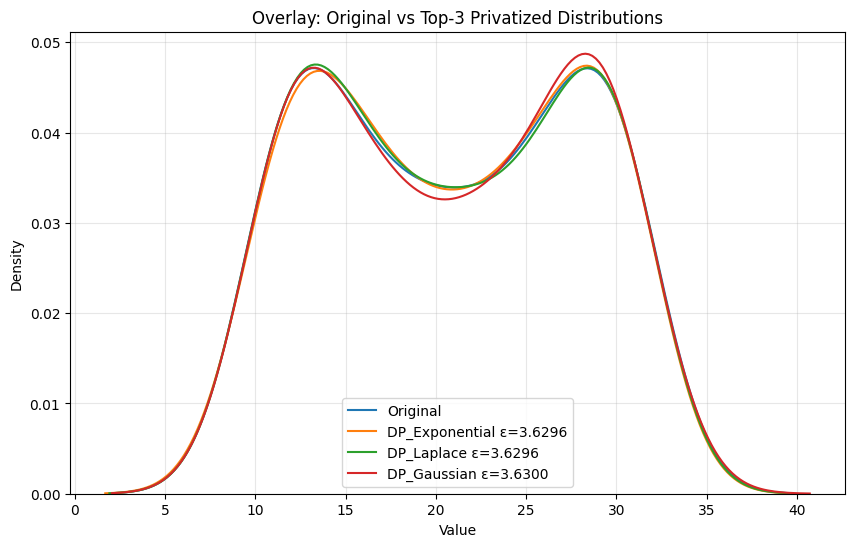


=== Dataset: Heart Rate (Min) ===
Top-3 Recommendations:
  DP_Exponential: ε=3.6291, mean_rmse=0.3854, ci_width=0.0149, reliability=174.14
  DP_Laplace: ε=3.6302, mean_rmse=0.3881, ci_width=0.0127, reliability=202.89
  DP_Gaussian: ε=3.6296, mean_rmse=0.9393, ci_width=0.0165, reliability=64.52

Similarity Metrics for Top-3:


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


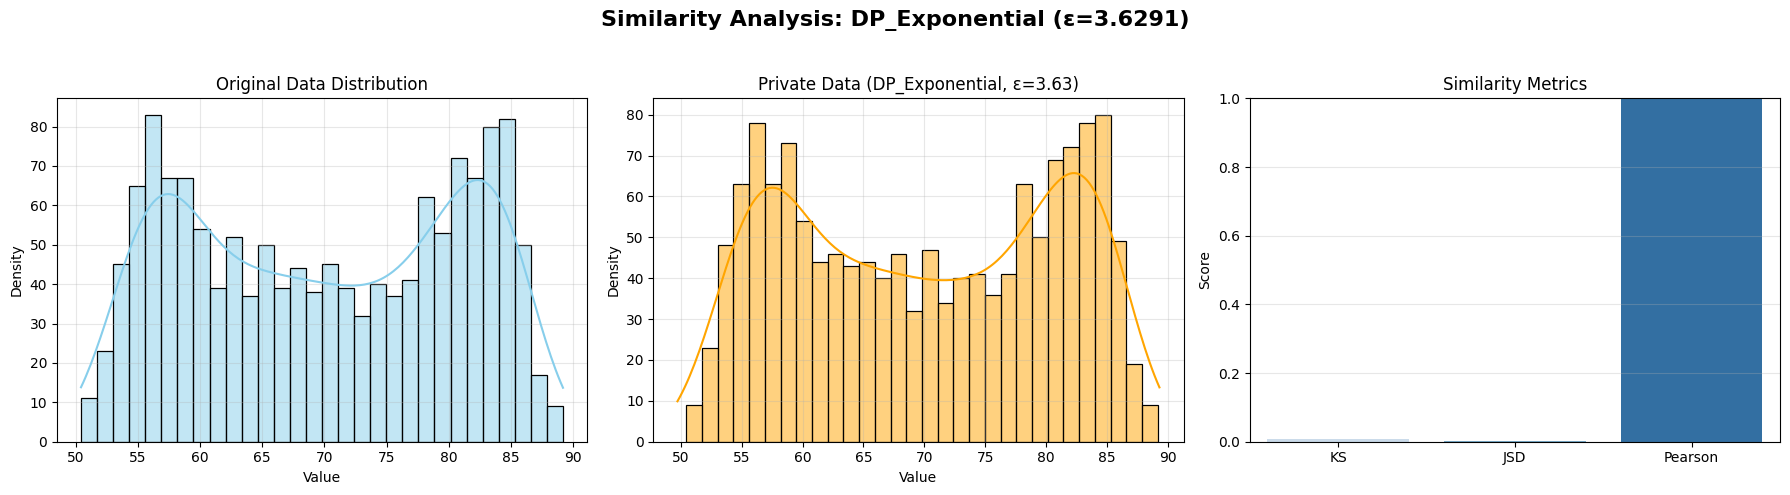

  DP_Exponential: KS=0.0083, JSD=0.0012, Pearson=0.9993


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


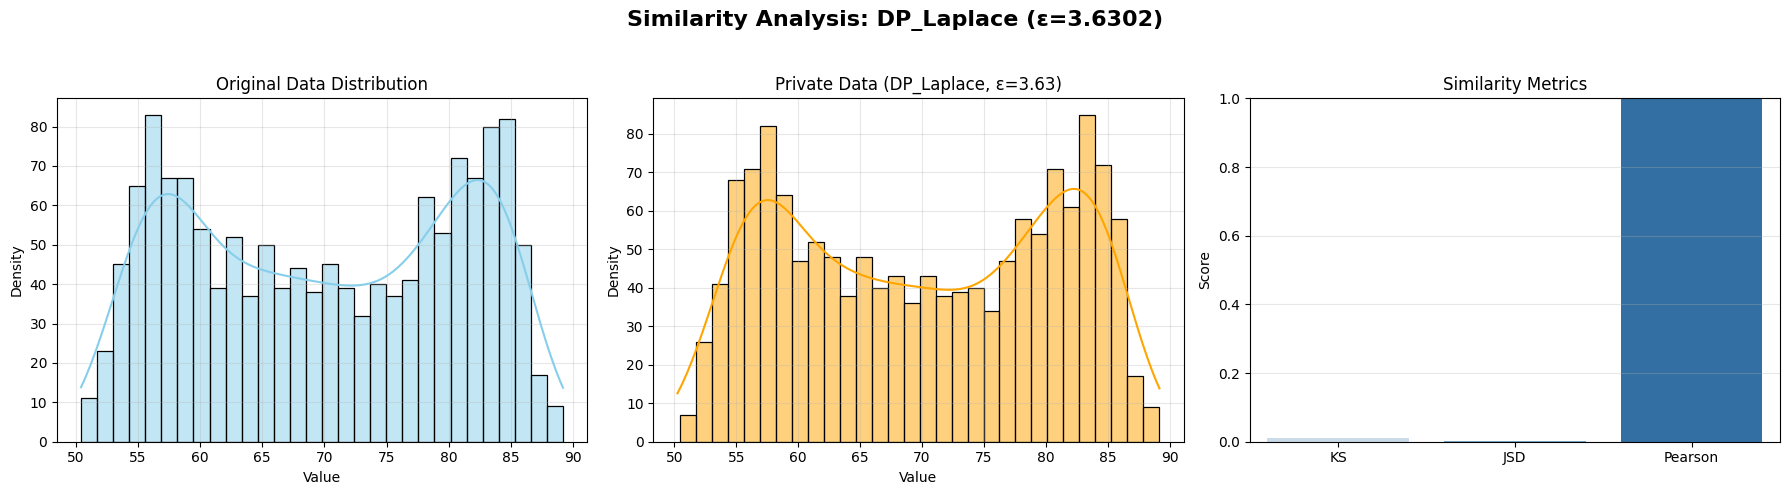

  DP_Laplace: KS=0.0097, JSD=0.0024, Pearson=0.9993


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


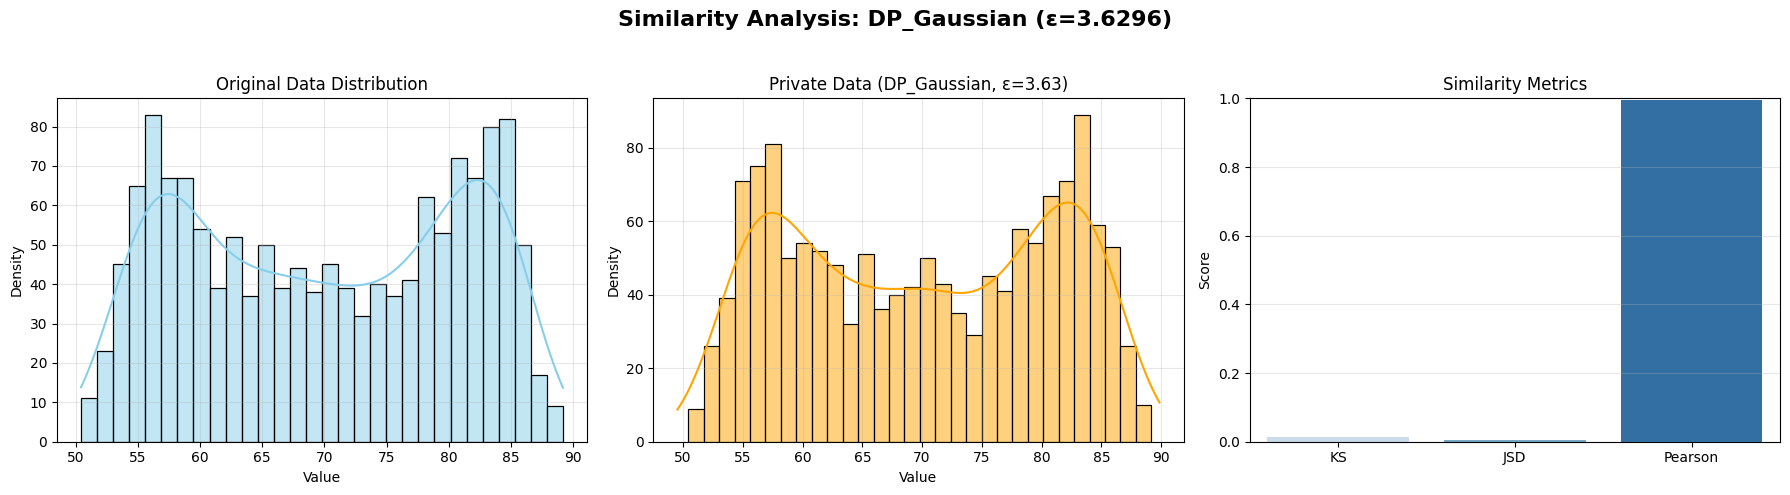

  DP_Gaussian: KS=0.0139, JSD=0.0045, Pearson=0.9963

Confidence Metrics for Top-3:
  DP_Exponential: mean_rmse=0.3928, ci_width=0.0128, reliability=198.89
  DP_Laplace: mean_rmse=0.3859, ci_width=0.0146, reliability=177.49
  DP_Gaussian: mean_rmse=0.9450, ci_width=0.0281, reliability=37.66


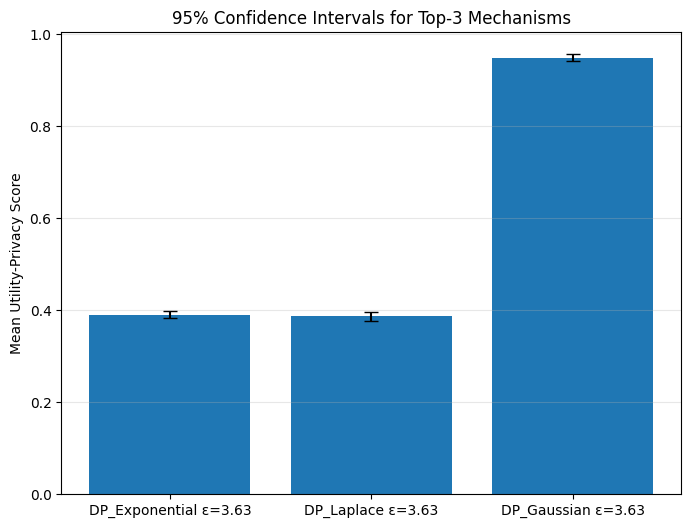

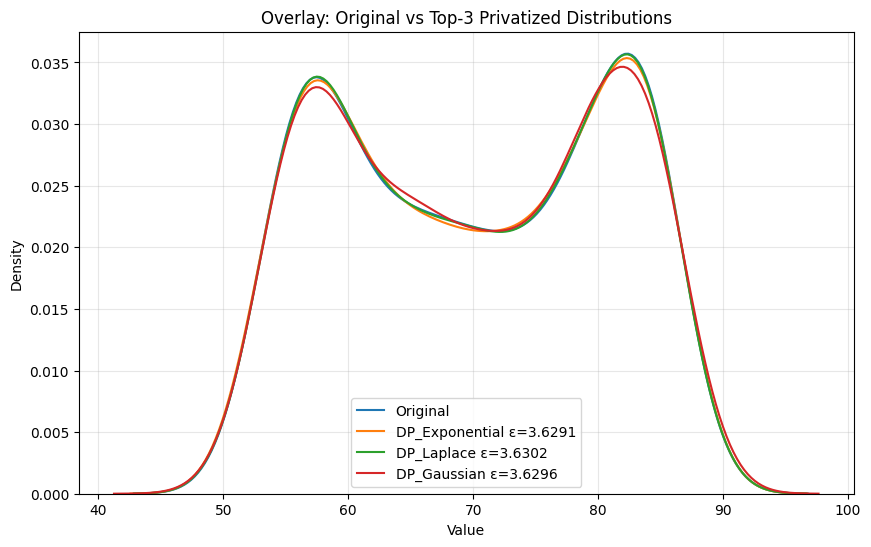


=== Dataset: Web Hits (5k) ===
Top-3 Recommendations:
  DP_Laplace: ε=3.6325, mean_rmse=0.3862, ci_width=0.0069, reliability=375.27
  DP_Exponential: ε=3.6296, mean_rmse=0.3891, ci_width=0.0072, reliability=356.95
  DP_Gaussian: ε=5.0000, mean_rmse=0.6850, ci_width=0.0076, reliability=192.09

Similarity Metrics for Top-3:


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


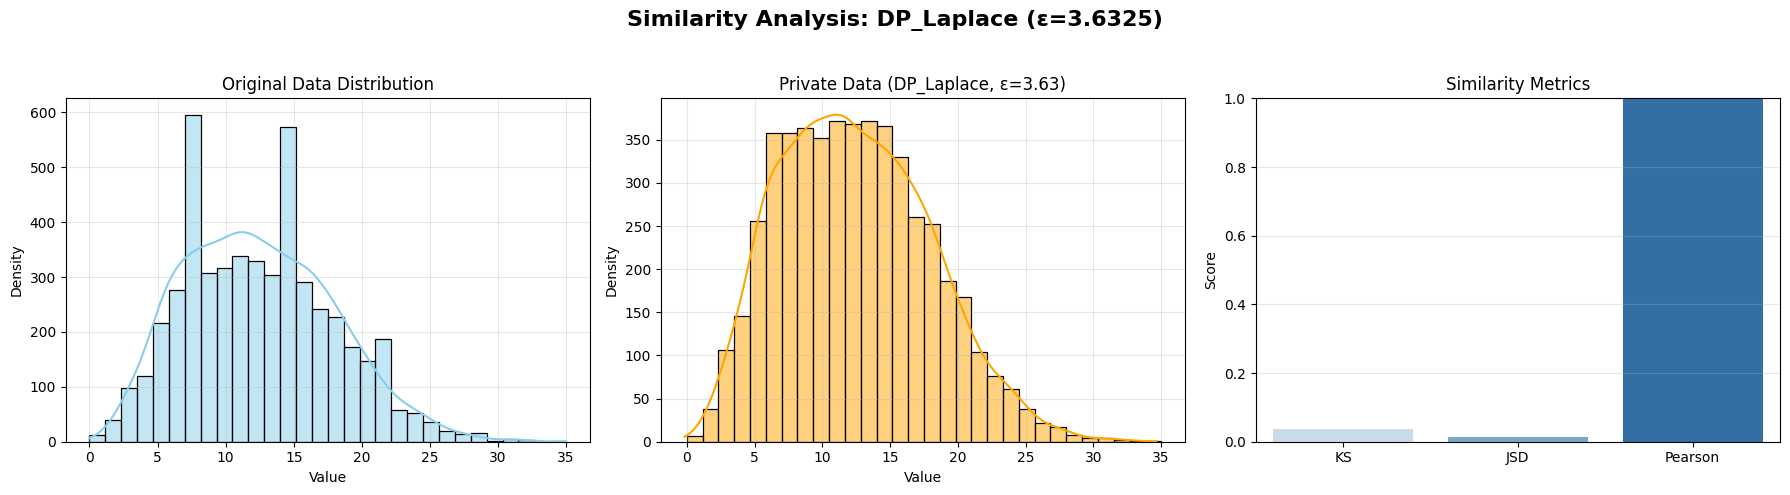

  DP_Laplace: KS=0.0366, JSD=0.0131, Pearson=0.9973


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


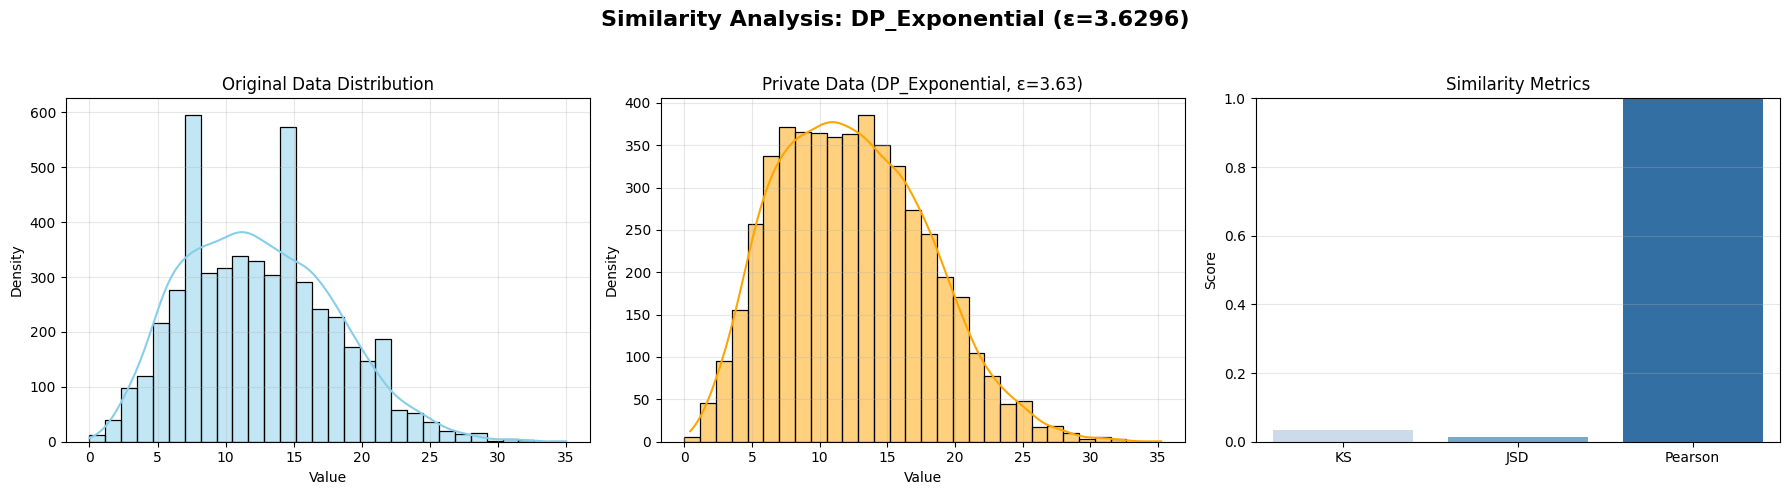

  DP_Exponential: KS=0.0346, JSD=0.0134, Pearson=0.9976


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


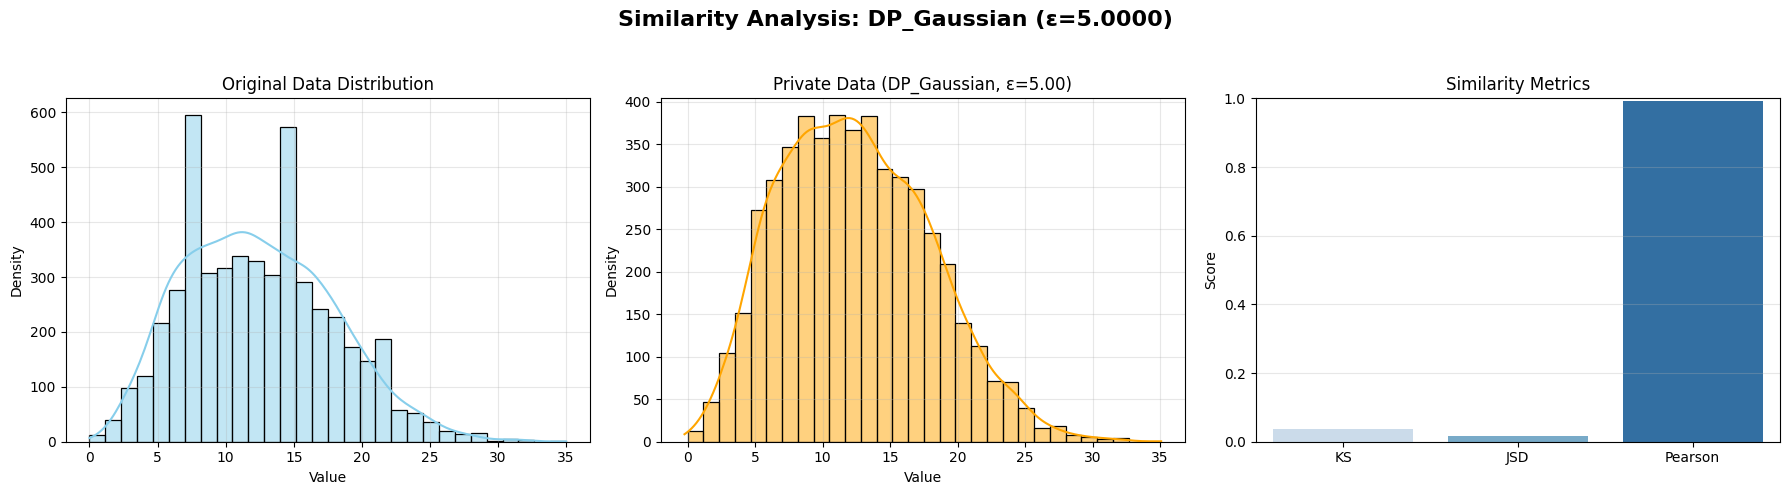

  DP_Gaussian: KS=0.0358, JSD=0.0158, Pearson=0.9924

Confidence Metrics for Top-3:
  DP_Laplace: mean_rmse=0.3907, ci_width=0.0078, reliability=328.14
  DP_Exponential: mean_rmse=0.3871, ci_width=0.0128, reliability=201.82
  DP_Gaussian: mean_rmse=0.6860, ci_width=0.0103, reliability=140.17


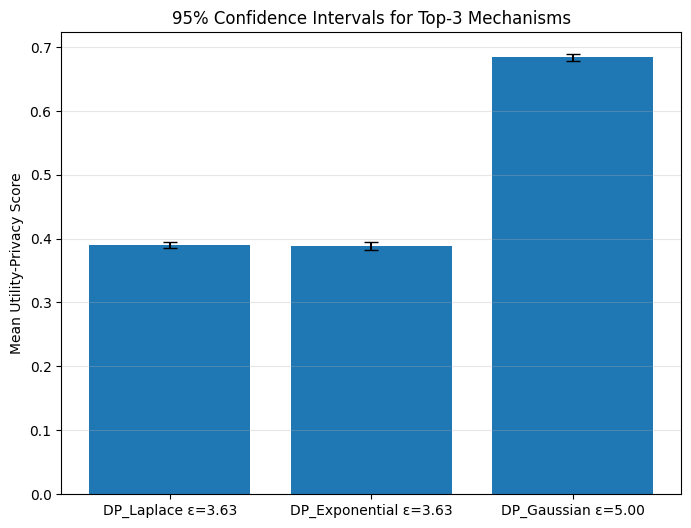

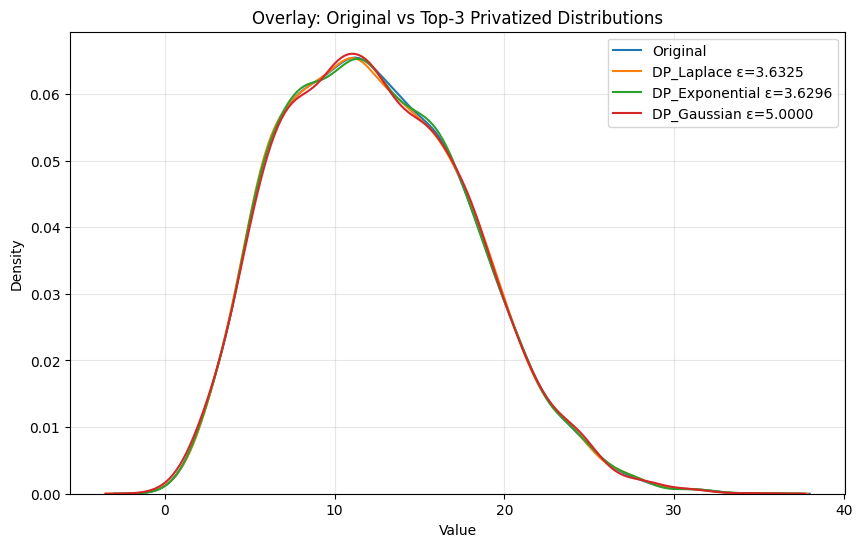


=== Dataset: Cat+Num ===
Top-3 Recommendations:
  DP_Exponential: ε=3.6296, mean_rmse=0.3867, ci_width=0.0080, reliability=323.25
  DP_Laplace: ε=3.6358, mean_rmse=0.3909, ci_width=0.0090, reliability=284.24
  DP_Gaussian: ε=5.0000, mean_rmse=0.6891, ci_width=0.0079, reliability=183.69

Similarity Metrics for Top-3:


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


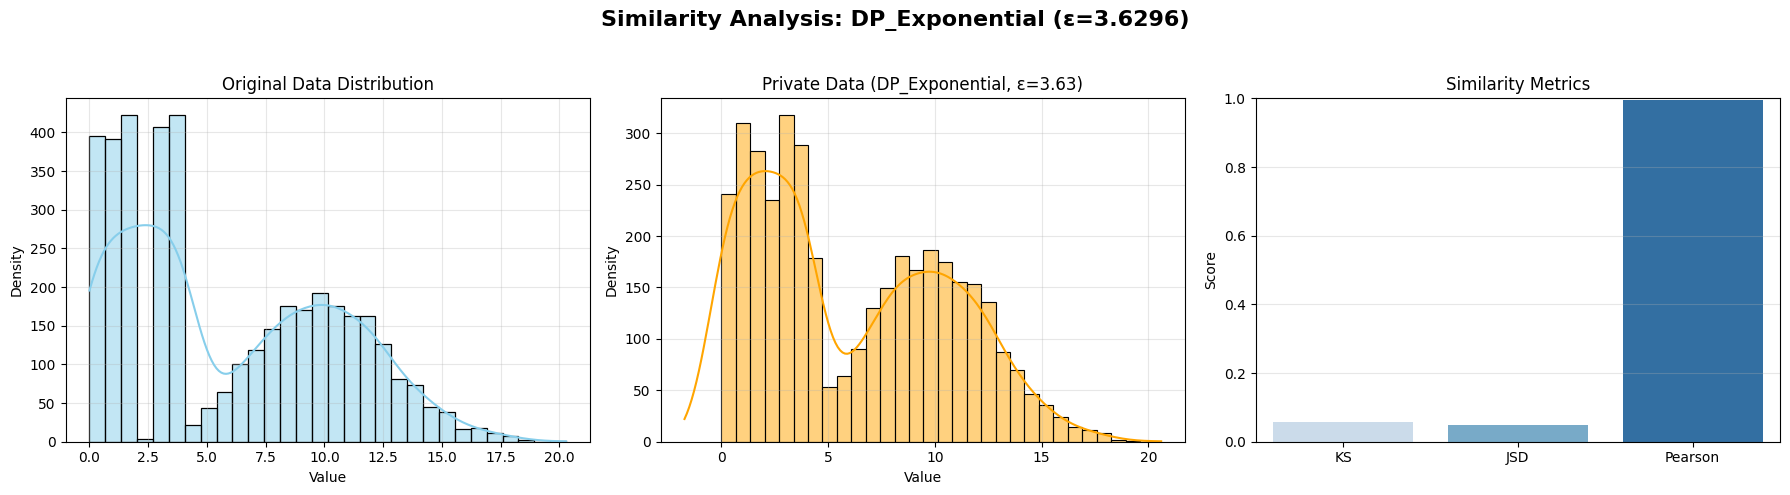

  DP_Exponential: KS=0.0560, JSD=0.0501, Pearson=0.9963


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


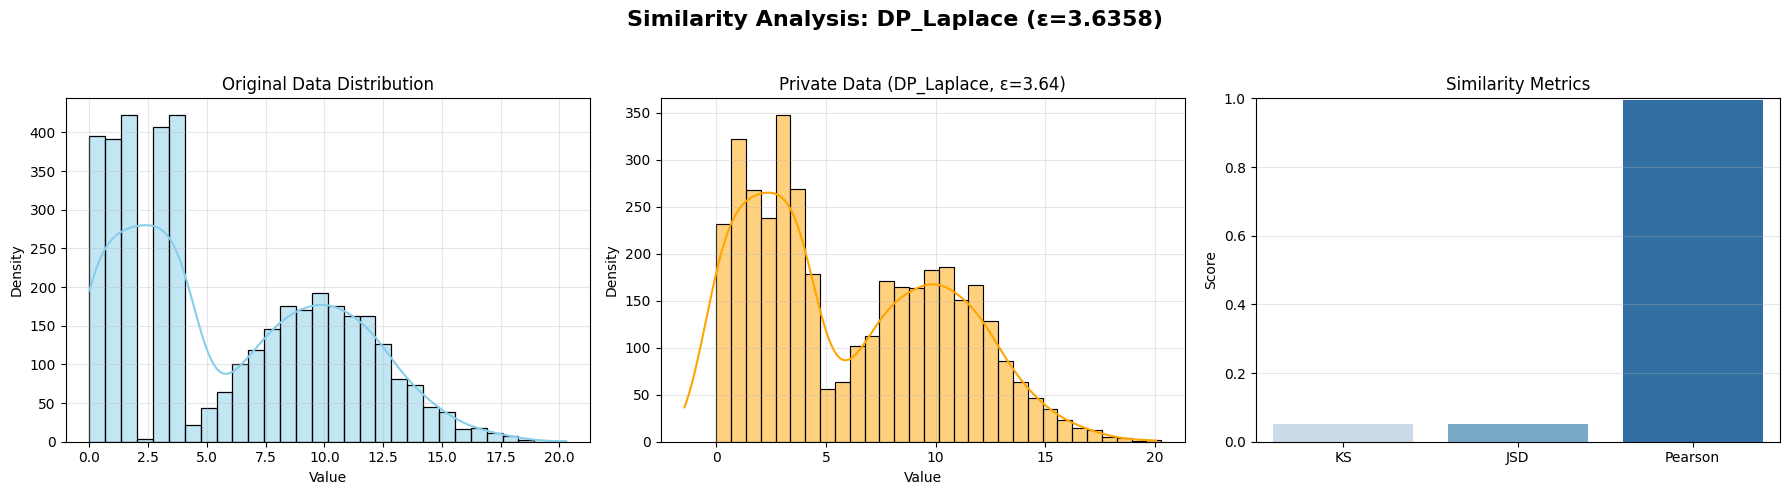

  DP_Laplace: KS=0.0530, JSD=0.0518, Pearson=0.9962


/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:608: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), ax=axes[2], palette="Blues")


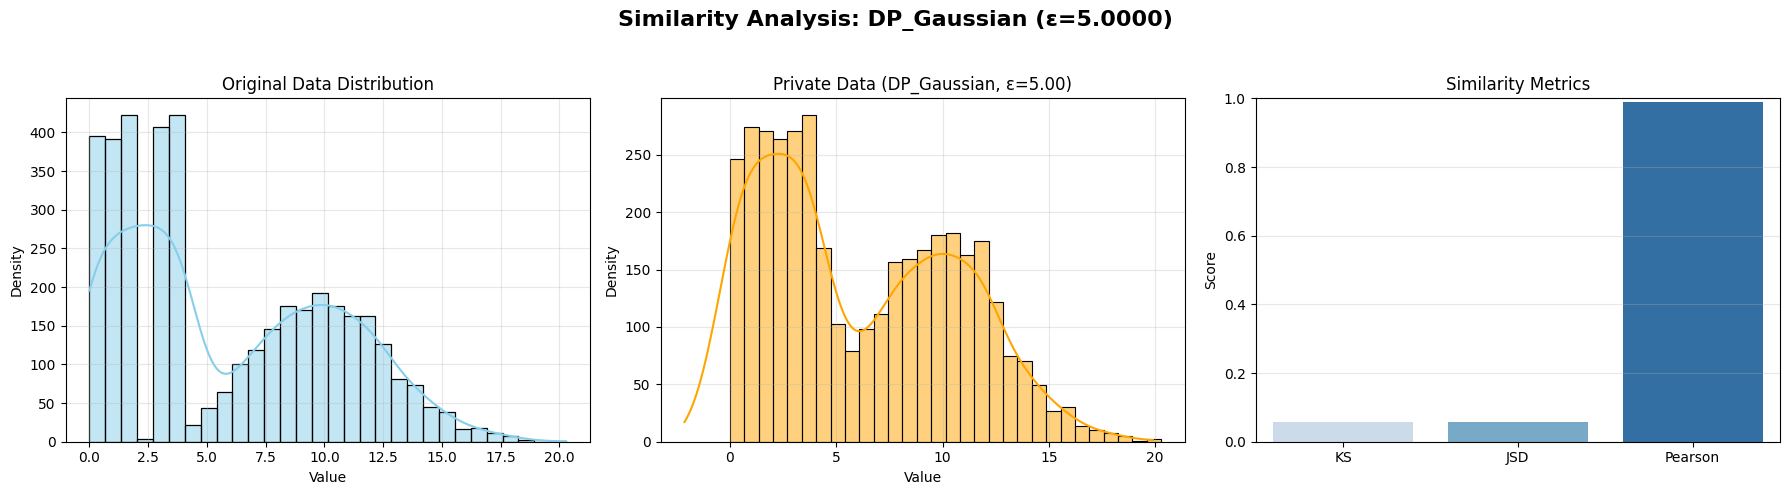

  DP_Gaussian: KS=0.0582, JSD=0.0584, Pearson=0.9890

Confidence Metrics for Top-3:
  DP_Exponential: mean_rmse=0.3888, ci_width=0.0076, reliability=334.03
  DP_Laplace: mean_rmse=0.3898, ci_width=0.0119, reliability=215.58
  DP_Gaussian: mean_rmse=0.6880, ci_width=0.0103, reliability=139.76


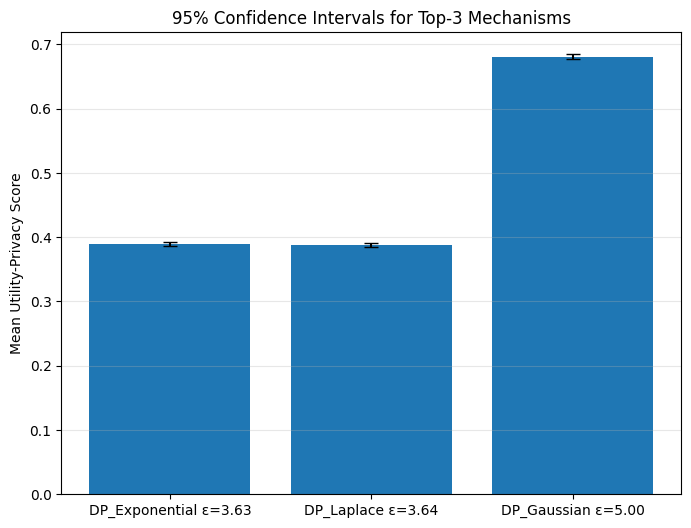

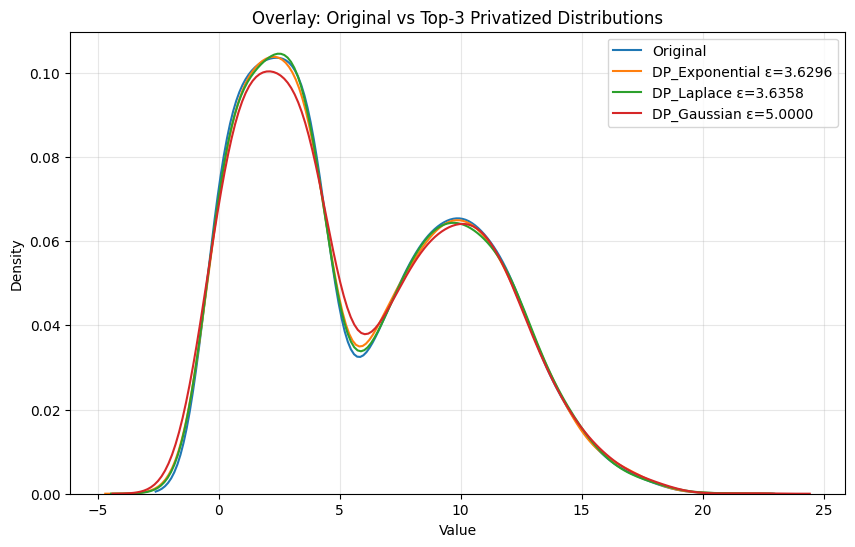

In [ ]:
# Identify the top 3 privacy algorithms for each input dataset.
if __name__ == "__main__":
    # 1) Generate all datasets
    all_data = generate_dataset()

    for name, tensor in all_data.items():
        print(f"\n=== Dataset: {name} ===")

        # For list-based APIs convert to Python list if needed
        domain = tensor.tolist()

        # 2) Top-3 Recommendations
        top3 = ornl_presto.recommend_top3(domain)
        print("Top-3 Recommendations:")
        for rec in top3:
            print(
                f"  {rec['algorithm']}: ε={rec['epsilon']:.4f}, "
                f"mean_rmse={rec['mean_rmse']:.4f}, ci_width={rec['ci_width']:.4f}, "
                f"reliability={rec['reliability']:.2f}"
            )

        # 3) Similarity Metrics
        print("\nSimilarity Metrics for Top-3:")
        for rec in top3:
            sim = ornl_presto.visualize_similarity(domain, rec['algorithm'], rec['epsilon'])
            print(
                f"  {rec['algorithm']}: KS={sim['KS']:.4f}, "
                f"JSD={sim['JSD']:.4f}, Pearson={sim['Pearson']:.4f}"
            )

        # 4) Confidence Metrics
        print("\nConfidence Metrics for Top-3:")
        for rec in top3:
            conf = ornl_presto.evaluate_algorithm_confidence(domain, rec['algorithm'], rec['epsilon'])
            rel = ornl_presto.performance_explanation_metrics(conf)['reliability']
            print(
                f"  {rec['algorithm']}: mean_rmse={conf['mean']:.4f}, "
                f"ci_width={conf['ci_width']:.4f}, reliability={rel:.2f}"
            )
        ornl_presto.visualize_confidence_top3(domain, top3)

        # 5) Overlay Original vs. Privatized
        ornl_presto.visualize_overlay_original_and_private(domain, top3)

/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:747: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sim, _ = pearsonr(orig_np, priv_np)


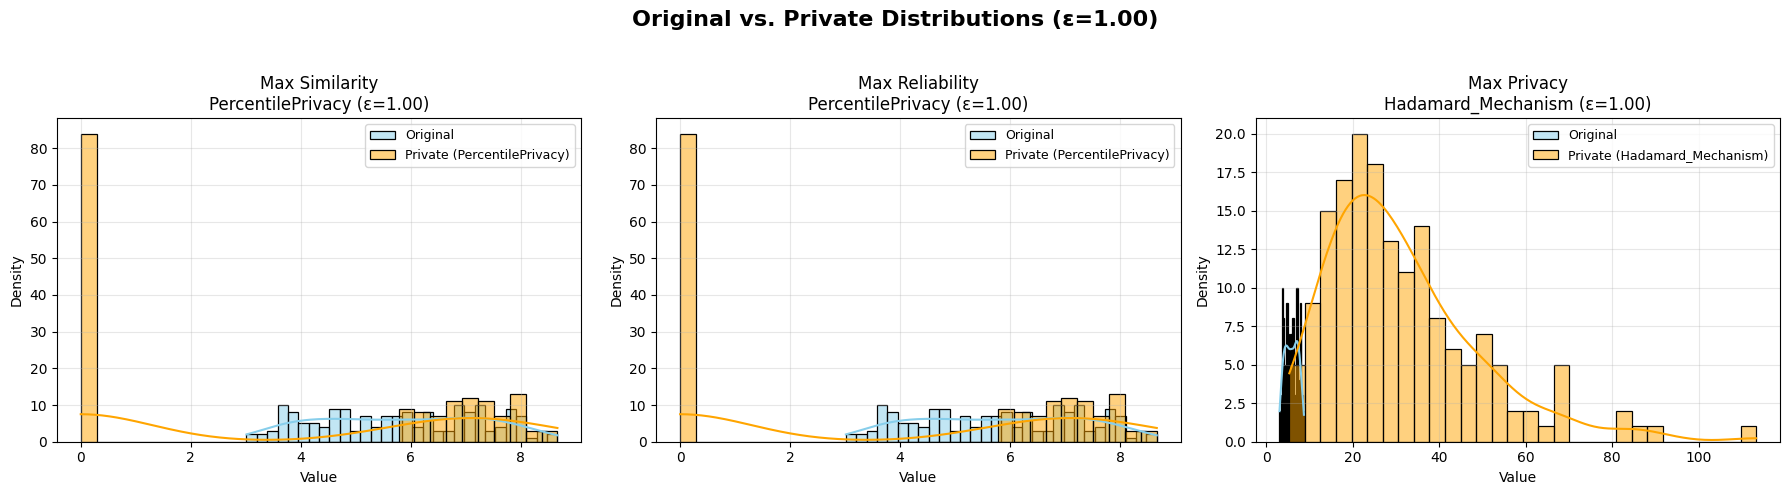

Best by Similarity:  {'algorithm': 'PercentilePrivacy', 'score': np.float32(0.9072)}
Best by Reliability: {'algorithm': 'PercentilePrivacy', 'score': inf}
Best by Privacy:     {'algorithm': 'Hadamard_Mechanism', 'score': 24.4379}


In [ ]:
# Identify the best privacy algorithms for fiven epsilon (ε).
epsilon = 1
dataset = generate_dataset()
name, tensor = next(iter(dataset.items()))

results = ornl_presto.recommend_best_algorithms(
    data                             = tensor,
    epsilon                          = epsilon,
    get_noise_generators             = ornl_presto.get_noise_generators,
    calculate_utility_privacy_score  = ornl_presto.calculate_utility_privacy_score,
    evaluate_algorithm_confidence    = ornl_presto.evaluate_algorithm_confidence,
    performance_explanation_metrics  = ornl_presto.performance_explanation_metrics
)

print("Best by Similarity: ",  results["max_similarity"])
print("Best by Reliability:", results["max_reliability"])
print("Best by Privacy:    ", results["max_privacy"])

/usr/local/lib/python3.11/dist-packages/ornl_presto/core.py:747: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  sim, _ = pearsonr(orig_np, priv_np)


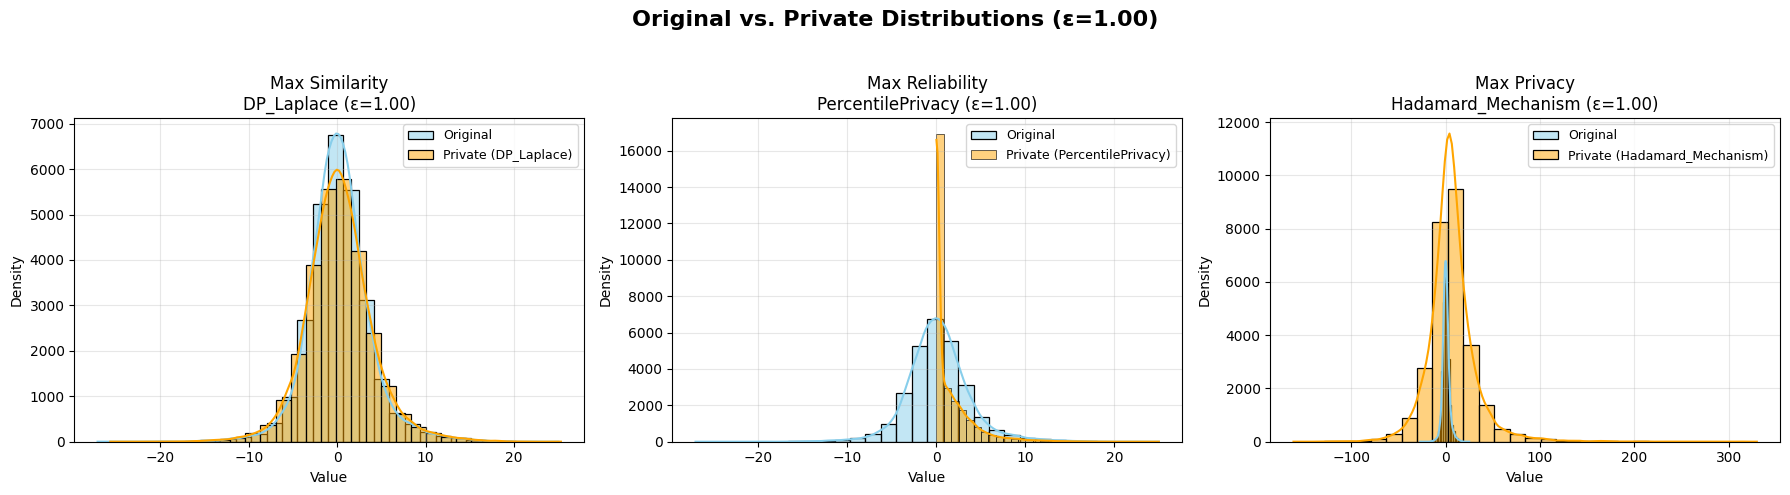

Baseline Accuracy (no privacy): 92.83%
DP Accuracy with 'PercentilePrivacy':        92.83%


In [ ]:
# Identify the best privacy algorithm for given epsilon for the gradients in DNN settings.

# 1) Generate synthetic classification data
X, y = make_classification(n_samples=2000, n_features=20, n_informative=15,
                           n_redundant=5, n_classes=2, random_state=42)
# Keep X_train and y_train as numpy arrays for now
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 2) Simple MLP model
class MLP(nn.Module):
    def __init__(self, in_features, hidden=50, num_classes=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, num_classes)
        )
    def forward(self, x):
        return self.net(x)

# 3) Baseline training (no privacy)
def train_and_evaluate(model, X_train_data, y_train_data, X_test_data, y_test_data):
    # Convert data to tensors with the model's dtype
    # Get the dtype from the first parameter of the model
    model_dtype = next(model.parameters()).dtype
    train_ds = TensorDataset(torch.tensor(X_train_data, dtype=model_dtype),
                             torch.tensor(y_train_data, dtype=torch.long))
    test_ds  = TensorDataset(torch.tensor(X_test_data,  dtype=model_dtype),
                             torch.tensor(y_test_data,  dtype=torch.long))
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=256)

    opt = optim.SGD(model.parameters(), lr=0.1)
    crit = nn.CrossEntropyLoss()
    # train
    model.train()
    for epoch in range(5):
        for xb, yb in train_loader:
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()
    # evaluate
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            preds = model(xb).argmax(dim=1)
            correct += (preds==yb).sum().item()
            total   += yb.size(0)
    return correct/total

# Data for recommendation: flatten all train inputs
# Use the original float32 for this part as it's used with the ornl_presto functions
flat_data = torch.tensor(X_train.flatten(), dtype=torch.float32)

epsilon = 1.0
results = ornl_presto.recommend_best_algorithms(
    data                             = flat_data,
    epsilon                          = epsilon,
    get_noise_generators             = ornl_presto.get_noise_generators,
    calculate_utility_privacy_score  = ornl_presto.calculate_utility_privacy_score,
    evaluate_algorithm_confidence    = ornl_presto.evaluate_algorithm_confidence,
    performance_explanation_metrics  = ornl_presto.performance_explanation_metrics
)

# Use max_reliability as per previous cells, assuming it yields a valid algorithm
# best_rel_algo = results["max_privacy"]['algorithm'] # Changed from max_privacy
best_rel_algo = results["max_reliability"]['algorithm']


# Baseline accuracy
# Initialize model before setting default dtype to ensure float32, or move the set_default_dtype later
# Alternatively, ensure the model is explicitly created with the desired dtype.
# Let's explicitly create with float64 since the default is set later.
base_model = MLP(20).to('cpu').to(torch.float64)
acc_base = train_and_evaluate(base_model, X_train, y_train, X_test, y_test)

# 4) DP training: apply best reliability algorithm to gradients
dp_model = MLP(20).to('cpu').to(torch.float64) # Ensure DP model is also float64
opt = optim.SGD(dp_model.parameters(), lr=0.1)
crit = nn.CrossEntropyLoss()
noise_fn = NOISE_GENERATORS[best_rel_algo]

dp_model.train()
for epoch in range(5):
    # Re-create data loader with appropriate dtype if train_and_evaluate isn't called
    # Get the dtype from the first parameter of the dp_model
    model_dtype = next(dp_model.parameters()).dtype
    train_ds_dp = TensorDataset(torch.tensor(X_train, dtype=model_dtype),
                                 torch.tensor(y_train, dtype=torch.long))
    train_loader_dp = DataLoader(train_ds_dp, batch_size=64, shuffle=True)

    for xb, yb in train_loader_dp:
        opt.zero_grad()
        logits = dp_model(xb)
        loss = crit(logits, yb)
        loss.backward()
        # apply privacy mechanism to gradients
        with torch.no_grad():
            for p in dp_model.parameters():
                if p.grad is not None:
                    g = p.grad
                    original_shape = g.shape
                    # Flatten the gradient
                    g_flat = g.flatten()
                    # Apply the noise function to the flattened gradient
                    # Ensure the noise_fn expects float input if casting g_flat
                    # Cast g_flat to float if noise_fn requires it, then back to original dtype for copy
                    noised_flat = noise_fn(g_flat.float(), epsilon).to(g.dtype)
                    # Reshape the noised gradient back to the original shape
                    noised = noised_flat.reshape(original_shape)
                    # Copy the noised gradient back
                    p.grad.copy_(noised)
        opt.step()

# DP evaluation
acc_dp = train_and_evaluate(dp_model, X_train, y_train, X_test, y_test) # Use the helper function for evaluation

print(f"Baseline Accuracy (no privacy): {acc_base*100:.2f}%")
print(f"DP Accuracy with '{best_rel_algo}':        {acc_dp*100:.2f}%")

/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epoch [10/10], Loss: 0.5127
Accuracy: 0.8750
0.8066912667575987


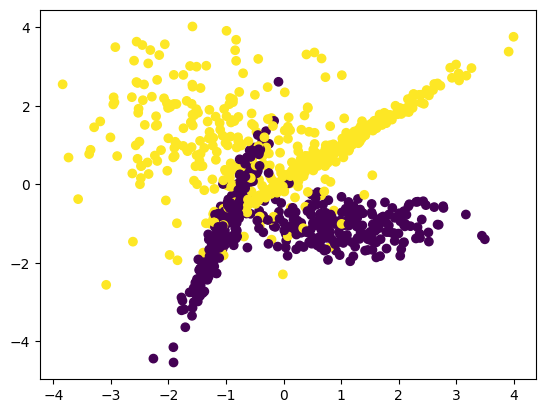

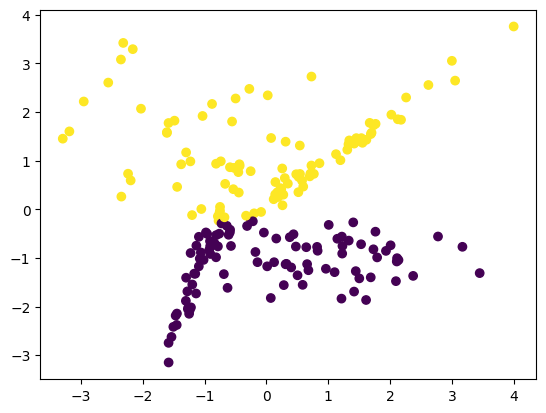

In [ ]:
# Baseline of ML algorithm, no privacy optimization.

X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

plt.figure()
plt.scatter(X[:,0], X[:,1],c=y)
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train)
X_test = torch.tensor(X_test)
y_train = torch.tensor(y_train)
y_test = torch.tensor(y_test)

# Create dataset and dataloader
train_dataset = TensorDataset(X_train, y_train)
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

class BinaryClassifier(nn.Module):
    def __init__(self, input_size):
        super(BinaryClassifier, self).__init__()
        self.linear1 = nn.Linear(input_size, 16)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.linear1(x)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.sigmoid(out)
        return out

model_class = BinaryClassifier

# Testing a simple binary classifier model.
accuracy, privacy_engine, predicted_classes = ornl_presto.dp_target(1., 1., model_class, X_test, train_dataset, y_test)

plt.figure()
plt.scatter(X_test[:,0],X_test[:,1], c=predicted_classes)
print(privacy_engine.get_epsilon(.1))

Epoch [10/10], Loss: 0.5188
Accuracy: 0.8550
0.8066912667575987


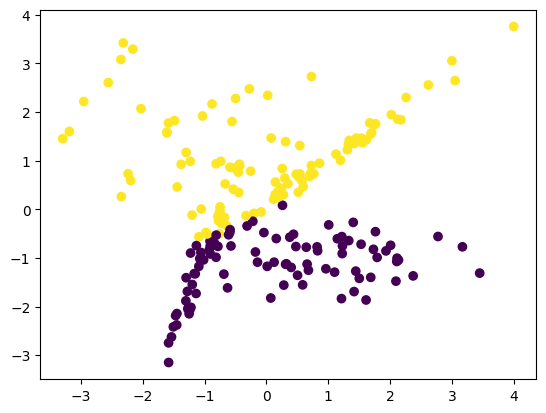

In [ ]:
class LogisticRegression(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, 1)

    def forward(self, x):
        y_predicted = torch.sigmoid(self.linear(x))
        return y_predicted

model_class = LogisticRegression
# Testing a simple Logistic regression / classification.
accuracy, privacy_engine, predicted_classes = ornl_presto.dp_target(1., 1., model_class, X_test, train_dataset, y_test)

plt.figure()
plt.scatter(X_test[:,0],X_test[:,1], c=predicted_classes)
print(privacy_engine.get_epsilon(.1))

In [ ]:
# This function uses Bayesian optimization to identify the pareto front for minimal epsilon and maximum accuracy by exploring
# the Opacus values of noise multiplier and max grad norm.
# The Bayesian Optimization algorithm used is random scalarization: https://arxiv.org/pdf/1805.12168.pdf
# The user provides their desired delta, which is used to compute epsilon.
# The user can then select their desired accuracy and epsilon from the pareto front and we can provide the optimal
# values of noise multiplier and max grad norm to achieve that accuracy and epsilon.

# Some data I computed by choosing the parameters myself.
# (noise multiplier, max grad norm): epsilon, accuracy
# (10, 1.): -0.09, .84
# (1.1, 1.): 0.62, .865
# (.1,.1): 650, .885
# (100., 1.): -.01, .51

x1 = np.logspace(np.log10(.1), np.log10(100), 20)
x2 = np.logspace(np.log10(.1), np.log10(10), 20)

model_class = BinaryClassifier

measured_points, epsilon_, accuracy_ = ornl_presto.dp_pareto_front(x1, x2, model_class, X_test, train_dataset, y_test)

run 0
Epoch [10/10], Loss: 0.5445
Accuracy: 0.8700
epsilon 0.006893392237054703
run 1
Epoch [10/10], Loss: 0.5863
Accuracy: 0.7650
epsilon -0.07979655170975981
run 2


/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Epoch [10/10], Loss: 0.4992
Accuracy: 0.8450
epsilon 1.1384452061086459
run 3
Epoch [10/10], Loss: 0.5245
Accuracy: 0.8900
epsilon 0.006893392237054703
run 4
Epoch [10/10], Loss: 0.3651
Accuracy: 0.8900
epsilon 11.973765654194159
run 5
Epoch [10/10], Loss: 0.5383
Accuracy: 0.8750
epsilon 0.13208145934407298
run 6
Epoch [10/10], Loss: 0.6516
Accuracy: 0.7050
epsilon -0.07979655170975981
run 7
Epoch [10/10], Loss: 0.5262
Accuracy: 0.8600
epsilon 0.13208145934407298
run 8
Epoch [10/10], Loss: 0.8512
Accuracy: 0.5050
epsilon -0.09525012325964487
run 9
Epoch [10/10], Loss: 0.5516
Accuracy: 0.8650
epsilon 1.1384452061086459
run 10
Epoch [10/10], Loss: 0.7319
Accuracy: 0.4550
epsilon -0.09525012322730615
run 11
Epoch [10/10], Loss: 0.6676
Accuracy: 0.6950
epsilon -0.052450949390505014
run 12
Epoch [10/10], Loss: 0.5720
Accuracy: 0.8750


/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the smallest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/prv/prvs.py:67: RuntimeWarning: overflow encountered in exp
  z = np.log(np.where(t > np.log(1 - q), (np.exp(t) + q - 1) / q, 1))
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/prv/prvs.py:67: RuntimeWarning: overflow encountered in divide
  z = np.log(np.where(t > np.log(1 - q), (np.exp(t) + q - 1) / q, 1))
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/prv/prvs.py:160: RuntimeWarning: overflow encountered in exp
  d2 = np.flip(np.flip(p * np.exp(-t)).cumsum())
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/prv/prvs.py:160: RuntimeWarning: invalid value encountered in accumulate
  d2 = np.flip(np.flip(p * np.exp(-t)).cumsum())
/usr/loc

epsilon 289.17675648284035
run 13
Epoch [10/10], Loss: 0.4976
Accuracy: 0.8750
epsilon 0.006893392237054703
run 14
Epoch [10/10], Loss: 0.7213
Accuracy: 0.4300
epsilon -0.09525012322730615
run 15
Epoch [10/10], Loss: 0.4473
Accuracy: 0.8750
epsilon 0.13208145934407298
run 16
Epoch [10/10], Loss: 0.6723
Accuracy: 0.4250
epsilon -0.09520834782918092
run 17
Epoch [10/10], Loss: 0.4955
Accuracy: 0.8800
epsilon 0.41117673353317574
run 18
Epoch [10/10], Loss: 0.5131
Accuracy: 0.8650
epsilon 0.13208145934407298
run 19
Epoch [10/10], Loss: 0.5176
Accuracy: 0.8650
epsilon 0.41117673353317574
run 20
Epoch [10/10], Loss: 0.7442
Accuracy: 0.4200
epsilon -0.09525012326075558
run 21
Epoch [10/10], Loss: 0.5261
Accuracy: 0.8800
epsilon 3.5014663748964714
run 22
Epoch [10/10], Loss: 0.7269
Accuracy: 0.3250
epsilon -0.09455037202158804
run 23
Epoch [10/10], Loss: 0.5046
Accuracy: 0.8700
epsilon 0.13208145934407298
run 24
Epoch [10/10], Loss: 0.5406
Accuracy: 0.7700
epsilon -0.07979655170975981
run 25
E

/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/prv/prvs.py:160: RuntimeWarning: invalid value encountered in multiply
  d2 = np.flip(np.flip(p * np.exp(-t)).cumsum())


epsilon 652.3254838405302
run 88
Epoch [10/10], Loss: 0.4408
Accuracy: 0.8050
epsilon 0.13208145934407298
run 89
Epoch [10/10], Loss: 0.4687
Accuracy: 0.8700
epsilon 1.1384452061086459
run 90
Epoch [10/10], Loss: 0.7321
Accuracy: 0.5200
epsilon -0.09525012322730615
run 91
Epoch [10/10], Loss: 0.5960
Accuracy: 0.8800
epsilon 0.13208145934407298
run 92
Epoch [10/10], Loss: 0.4122
Accuracy: 0.8800
epsilon 39.80273121224778
run 93
Epoch [10/10], Loss: 0.4248
Accuracy: 0.8450
epsilon 0.006893392237054703
run 94
Epoch [10/10], Loss: 0.5258
Accuracy: 0.8800
epsilon -0.0910030463504027
run 95
Epoch [10/10], Loss: 0.5486
Accuracy: 0.8650
epsilon -0.052450949390505014
run 96
Epoch [10/10], Loss: 0.6293
Accuracy: 0.6700
epsilon -0.07979655170975981
run 97
Epoch [10/10], Loss: 0.4145
Accuracy: 0.8700
epsilon 0.13208145934407298
run 98
Epoch [10/10], Loss: 0.3277
Accuracy: 0.8800
epsilon 1.1384452061086459
run 99
Epoch [10/10], Loss: 0.3381
Accuracy: 0.8850
epsilon 0.41117673353317574


[  0.1          0.14384499   0.20691381   0.29763514   0.42813324
   0.61584821   0.88586679   1.27427499   1.83298071   2.6366509
   3.79269019   5.45559478   7.8475997   11.28837892  16.23776739
  23.35721469  33.59818286  48.32930239  69.51927962 100.        ]


Text(0, 0.5, 'accuracy')

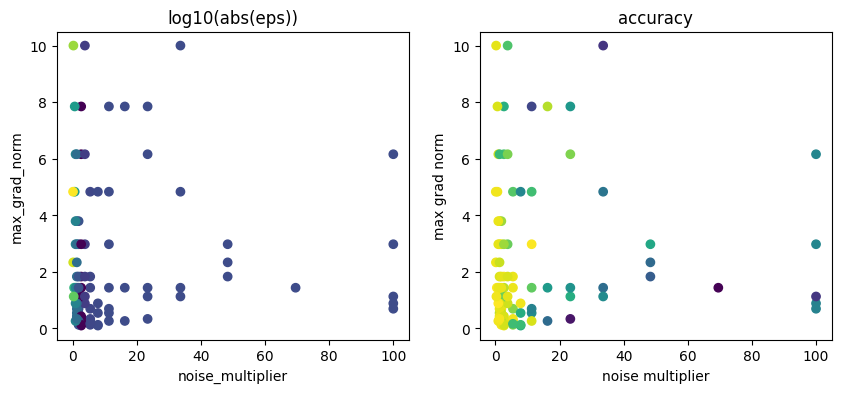

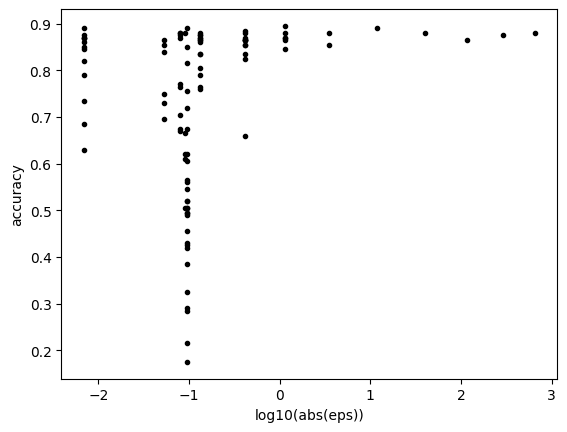

In [ ]:
x1 = np.logspace(np.log10(.1), np.log10(100), 20)
x2 = np.logspace(np.log10(.1), np.log10(10), 20)
print(x1)
xg1, xg2 = np.meshgrid(x1, x2)
Xg = np.hstack((xg1.flatten()[:,None], xg2.flatten()[:,None]))

measured_points = measured_points.astype(int)
plt.figure(figsize = (10,4))
plt.subplot(1,2,1)
plt.scatter(Xg[measured_points,0], Xg[measured_points,1], c=np.log10(np.abs(np.asarray(epsilon_))))
plt.xlabel('noise_multiplier')
plt.ylabel('max_grad_norm')
plt.title('log10(abs(eps))')
plt.subplot(1,2,2)
plt.scatter(Xg[measured_points,0], Xg[measured_points,1], c=np.asarray(accuracy_))
plt.xlabel('noise multiplier')
plt.ylabel('max grad norm')
plt.title('accuracy')
plt.figure()
plt.plot(np.log10(np.asarray(np.abs(epsilon_))), np.asarray(accuracy_), 'k.')
plt.xlabel('log10(abs(eps))')
plt.ylabel('accuracy')

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Define the neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_class = SimpleNN
best_params, best_accuracy = ornl_presto.dp_hyper(model_class, train_dataset, test_dataset, SEED)

print("\nBest parameters found:")
print(f"Noise multiplier: {best_params['noise_multiplier']:.4f}")
print(f"Batch size: {int(round(best_params['batch_size']))}")
print(f"Learning rate: {best_params['learning_rate']:.5f}")
print(f"Clipping norm: {best_params['clipping_norm']:.3f}")
print(f"Best Accuracy: {best_accuracy:.2f}%")

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 2.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.95MB/s]


|   iter    |  target   | batch_... | clippi... | learni... | noise_... |
-------------------------------------------------------------------------
Epsilon spent: 0.059
Accuracy: 69.20%
| 1         | 0.0       | 57.95     | 1.906     | 0.007323  | 1.997     |
Epsilon spent: 0.035
Accuracy: 57.61%
| 2         | 0.0       | 33.47     | 0.3964    | 0.0005903 | 2.665     |
Epsilon spent: 0.048
Accuracy: 48.14%
| 3         | 0.0       | 83.32     | 1.445     | 0.0002156 | 2.925     |
Epsilon spent: 0.255
Accuracy: 86.01%
| 4         | 86.01     | 109.2     | 0.5034    | 0.001826  | 0.9585    |
Epsilon spent: 0.100
Accuracy: 81.19%
| 5         | 0.0       | 50.08     | 1.097     | 0.004325  | 1.228     |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epsilon spent: 4.102
Accuracy: 88.17%
| 6         | 88.17     | 126.6     | 0.1       | 0.003092  | 0.5       |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Epsilon spent: 0.055
Accuracy: 70.13%
| 7         | 0.0       | 118.3     | 2.0       | 0.01      | 3.0       |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epsilon spent: 0.925
Accuracy: 82.81%
| 8         | 0.0       | 127.6     | 0.3313    | 0.001246  | 0.7176    |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epsilon spent: 0.197
Accuracy: 83.79%
| 9         | 0.0       | 109.2     | 0.6042    | 0.001935  | 1.07      |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epsilon spent: 0.505
Accuracy: 81.89%
| 10        | 0.0       | 68.81     | 0.4049    | 0.008022  | 0.7413    |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Epsilon spent: 0.055
Accuracy: 79.08%
| 11        | 0.0       | 121.1     | 1.442     | 0.004507  | 2.996     |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epsilon spent: 0.118
Accuracy: 83.91%
| 12        | 0.0       | 102.8     | 1.776     | 0.002279  | 1.431     |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Epsilon spent: 0.040
Accuracy: 75.46%
| 13        | 0.0       | 37.68     | 1.28      | 0.00249   | 2.419     |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epsilon spent: 0.038
Accuracy: 45.32%
| 14        | 0.0       | 16.71     | 0.9726    | 0.009767  | 1.817     |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epsilon spent: 2.689
Accuracy: 88.28%
| 15        | 88.28     | 99.17     | 1.098     | 0.00301   | 0.5492    |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epsilon spent: 0.092
Accuracy: 80.99%
| 16        | 0.0       | 115.3     | 1.109     | 0.002576  | 1.828     |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


Epsilon spent: 0.562
Accuracy: 65.61%
| 17        | 0.0       | 39.09     | 1.943     | 0.0001532 | 0.6737    |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Epsilon spent: 0.048
Accuracy: 60.04%
| 18        | 0.0       | 66.22     | 0.267     | 0.0005266 | 2.592     |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Epsilon spent: 0.029
Accuracy: 35.23%
| 19        | 0.0       | 25.3      | 1.617     | 0.009221  | 2.929     |


/usr/local/lib/python3.11/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/opacus/accountants/analysis/rdp.py:332: UserWarning: Optimal order is the largest alpha. Please consider expanding the range of alphas to get a tighter privacy bound.
  warnings.warn(


Epsilon spent: 0.054
Accuracy: 69.92%
| 20        | 0.0       | 56.83     | 0.6448    | 0.006926  | 2.168     |

Best parameters found:
Noise multiplier: 0.5492
Batch size: 99
Learning rate: 0.00301
Clipping norm: 1.098
Best Accuracy: 88.28%
